# Using Machine Learning to predict solubility of solutes in polymers

Data source: Predicting the solubility of gases, vapors, and supercritical fluids in amorphous polymers from electron density using convolutional neural networks. URL: https://doi.org/10.1039/D3PY01028G

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

import os

RANDOM_SEED = 1

## Data Exploration

In [2]:
# Print all files in the ../data directory
data_dir = "../data/raw"
if os.path.exists(data_dir):
    files = os.listdir(data_dir)
    print(f"Files in {data_dir}:")
    for file in files:
        print(f" - {file}")
else:
    print(f"Directory {data_dir} does not exist")

Files in ../data/raw:
 - experimental_dataset.csv
 - list_of_polymers.csv
 - list_of_solvents.csv
 - polymers.txt
 - polymer_mass.csv
 - solvents.txt
 - solvent_macro_features.csv
 - solvent_mass.csv
 - test_pairs.csv
 - val_pairs.csv


In [3]:
df_exp = pd.read_csv("../data/raw/experimental_dataset.csv")
df_pinfo = pd.read_csv("../data/raw/list_of_polymers.csv")
df_sinfo = pd.read_csv("../data/raw/list_of_solvents.csv")

Joining databases:

In [4]:
df_merge1 = pd.merge(left = df_pinfo, right = df_exp, left_on = "polymer", right_on = "polymer", how = "left")
df_full = pd.merge(left = df_sinfo, right = df_merge1, left_on = "solvent", right_on = "solvent", how = "left")

In [5]:
# Create a new column with all possible combinations
df_full["sol-pol"] = df_full["polymer"].astype(str) + " - " + df_full["solvent"].astype(str)

# Count the number of unique elements in the combined column
n_unique_SolPol = df_full["sol-pol"].nunique()
print(n_unique_SolPol)

515


Compare columns before and after merging:

In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15966 entries, 0 to 15965
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   solvent      15966 non-null  int64  
 1   formula      15966 non-null  object 
 2   name_x       15966 non-null  object 
 3   stype        15966 non-null  object 
 4   polymer      15964 non-null  float64
 5   abr          15964 non-null  object 
 6   name_y       12759 non-null  object 
 7   ptype        15964 non-null  object 
 8   expno        15964 non-null  float64
 9   mn           15964 non-null  float64
 10  mw           15964 non-null  float64
 11  cryst        15964 non-null  float64
 12  tg           15964 non-null  float64
 13  dens         15964 non-null  float64
 14  pressure     15964 non-null  float64
 15  temperature  15964 non-null  float64
 16  wa           15964 non-null  float64
 17  doi          15964 non-null  object 
 18  notes        15925 non-null  object 
 19  sol-

In [7]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15966 entries, 0 to 15965
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   solvent      15966 non-null  int64  
 1   formula      15966 non-null  object 
 2   name_x       15966 non-null  object 
 3   stype        15966 non-null  object 
 4   polymer      15964 non-null  float64
 5   abr          15964 non-null  object 
 6   name_y       12759 non-null  object 
 7   ptype        15964 non-null  object 
 8   expno        15964 non-null  float64
 9   mn           15964 non-null  float64
 10  mw           15964 non-null  float64
 11  cryst        15964 non-null  float64
 12  tg           15964 non-null  float64
 13  dens         15964 non-null  float64
 14  pressure     15964 non-null  float64
 15  temperature  15964 non-null  float64
 16  wa           15964 non-null  float64
 17  doi          15964 non-null  object 
 18  notes        15925 non-null  object 
 19  sol-

Exploring the distribution in each column:

array([[<Axes: title={'center': 'solvent'}>,
        <Axes: title={'center': 'polymer'}>,
        <Axes: title={'center': 'expno'}>],
       [<Axes: title={'center': 'mn'}>, <Axes: title={'center': 'mw'}>,
        <Axes: title={'center': 'cryst'}>],
       [<Axes: title={'center': 'tg'}>, <Axes: title={'center': 'dens'}>,
        <Axes: title={'center': 'pressure'}>],
       [<Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'wa'}>, <Axes: >]], dtype=object)

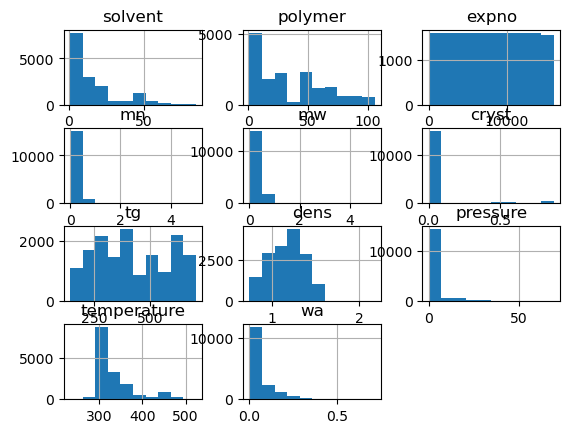

In [8]:
df_full.hist()

In [9]:
df_full.head()

solvent formula          name_x stype  polymer       abr  \
0        1     CO2  carbon dioxide    OX      1.0  Matrimid   
1        1     CO2  carbon dioxide    OX      1.0  Matrimid   
2        1     CO2  carbon dioxide    OX      1.0  Matrimid   
3        1     CO2  carbon dioxide    OX      1.0  Matrimid   
4        1     CO2  carbon dioxide    OX      1.0  Matrimid   

                                              name_y ptype  expno       mn  \
0  5(6)- amino-1-(4'-aminophenyl)-1,3,-trimethyli...    PI   29.0  18000.0   
1  5(6)- amino-1-(4'-aminophenyl)-1,3,-trimethyli...    PI   30.0  18000.0   
2  5(6)- amino-1-(4'-aminophenyl)-1,3,-trimethyli...    PI   31.0  18000.0   
3  5(6)- amino-1-(4'-aminophenyl)-1,3,-trimethyli...    PI   32.0  18000.0   
4  5(6)- amino-1-(4'-aminophenyl)-1,3,-trimethyli...    PI   33.0  18000.0   

        mw  cryst     tg   dens  pressure  temperature        wa  \
0  80000.0    0.0  611.0  1.225  0.096330       296.15  0.024814   
1  80000.0    0.0  611.0  1.225  0.444954       296.15  0.048406   
2  80000.0    0.0  611.0  1.225  0.779817       296.15  0.061171   
3  80000.0    0.0  611.0  1.225  1.133028       296.15  0.070268   
4  80000.0    0.0  611.0  1.225  1.477064       296.15  0.077454   

                             doi  \
0  10.1016/S0376-7388(02)00385-X   
1  10.1016/S0376-7388(02)00385-X   
2  10.1016/S0376-7388(02)00385-X   
3  10.1016/S0376-7388(02)00385-X   
4  10.1016/S0376-7388(02)00385-X   

                                               notes  sol-pol  
0  Matrimid; INCOMPLETE CHARACTERIZATION WARNING;...  1.0 - 1  
1  Matrimid; INCOMPLETE CHARACTERIZATION WARNING;...  1.0 - 1  
2  Matrimid; INCOMPLETE CHARACTERIZATION WARNING;...  1.0 - 1  
3  Matrimid; INCOMPLETE CHARACTERIZATION WARNING;...  1.0 - 1  
4  Matrimid; INCOMPLETE CHARACTERIZATION WARNING;...  1.0 - 1

In [10]:
# Rename
df_full.rename(columns = {'formula': 'sol',
                       'abr': 'pol'}, inplace = True)

df_full['sol'] = df_full['sol'].astype('category')
df_full['pol'] = df_full['pol'].astype('category')

In [11]:
print("Unique solvents:", df_full['sol'].unique())

print()
print("Unique polymers:", df_full['pol'].unique())


Unique solvents: ['CO2', 'CH4', 'C4H10', 'CClF2CH3', 'CF3CH2F', ..., 'C4H8O2', 'C2H5COC2H5', 'C3H7OC3H7', 'CH3NO2', '(C2H3)OCOCH3']
Length: 73
Categories (73, object): ['(C2H3)OCOCH3', 'Ar', 'C2F6', 'C2H2', ..., 'PO(CH3)(OCH3)2', 'SF6', 'SO2', 'Xe']

Unique polymers: ['Matrimid', 'PCL', 'PE', 'PEG', 'PET', ..., 'PEV', 'P4VP', 'PVME', '6FDA-5CMPD', '6FDA-44DDM']
Length: 106
Categories (105, object): ['6FDA-34DPE', '6FDA-44DDM', '6FDA-4`4-DPE', '6FDA-5CMPD', ..., 'TMPSF', 'mPBI', 'poly(2-EAdMA)', 'poly(2-MAdMA)']


Limit prediction to CO2 only:

In [12]:
df_co2=df_full.loc[df_full["sol"] == "CO2"]

In [13]:
df_co2['sol'].unique()

['CO2']
Categories (73, object): ['(C2H3)OCOCH3', 'Ar', 'C2F6', 'C2H2', ..., 'PO(CH3)(OCH3)2', 'SF6', 'SO2', 'Xe']

# Data exploration

## Visualise our Feature / Target Relationship

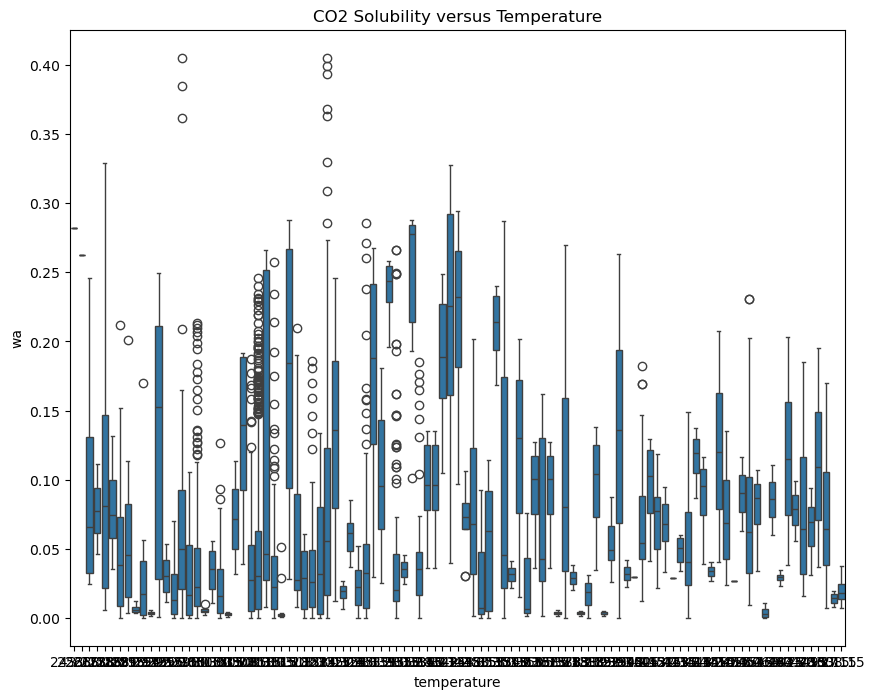

In [14]:
# Temperature
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='temperature', y='wa')
ax.set_title('CO2 Solubility versus Temperature')
plt.show()

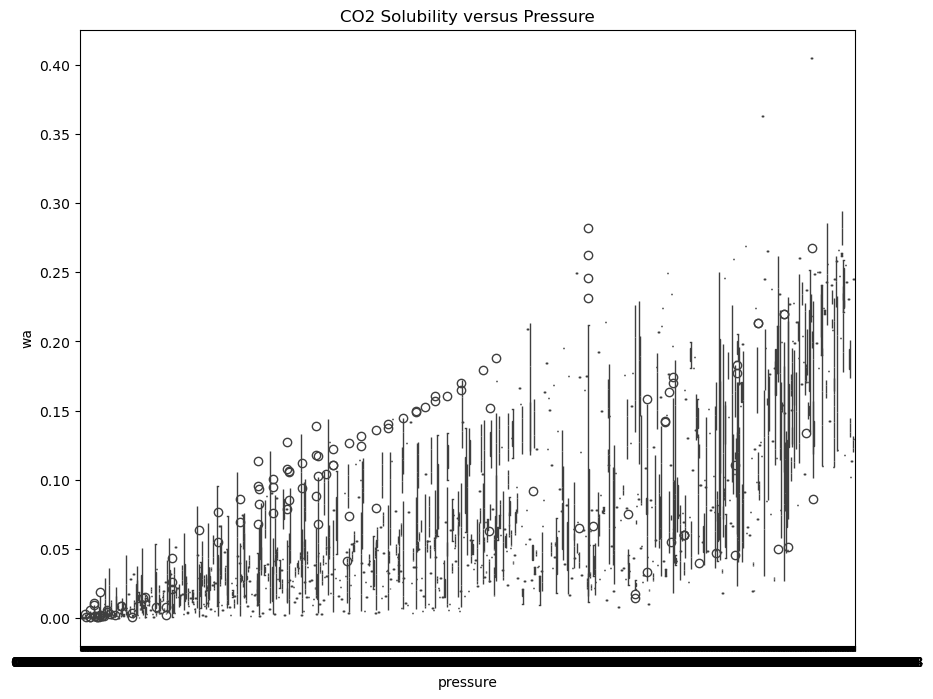

In [15]:
# Pressure
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='pressure', y='wa')
ax.set_title('CO2 Solubility versus Pressure')
plt.show()

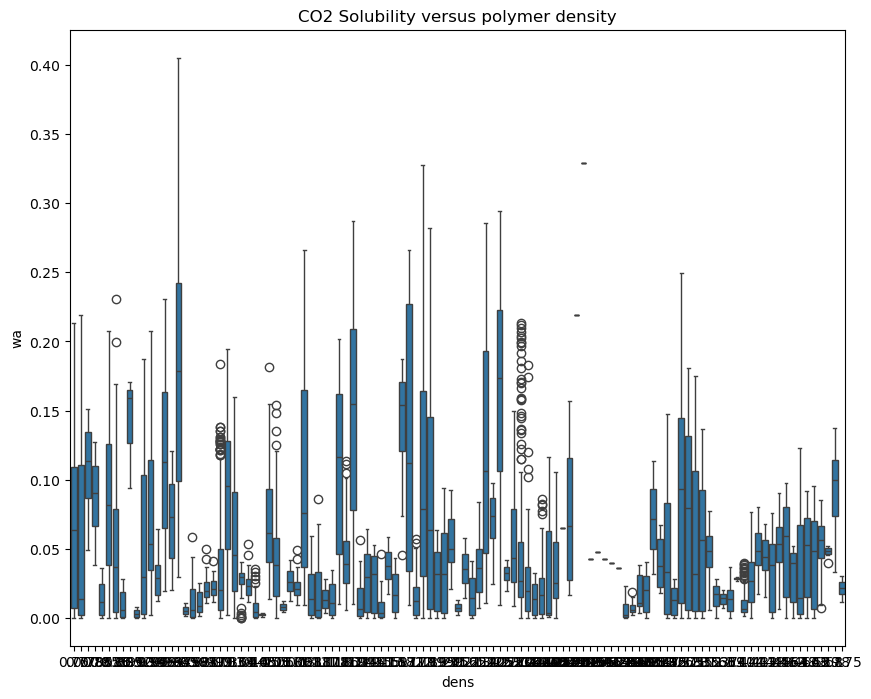

In [16]:
# Density
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='dens', y='wa')
ax.set_title('CO2 Solubility versus polymer density')
plt.show()

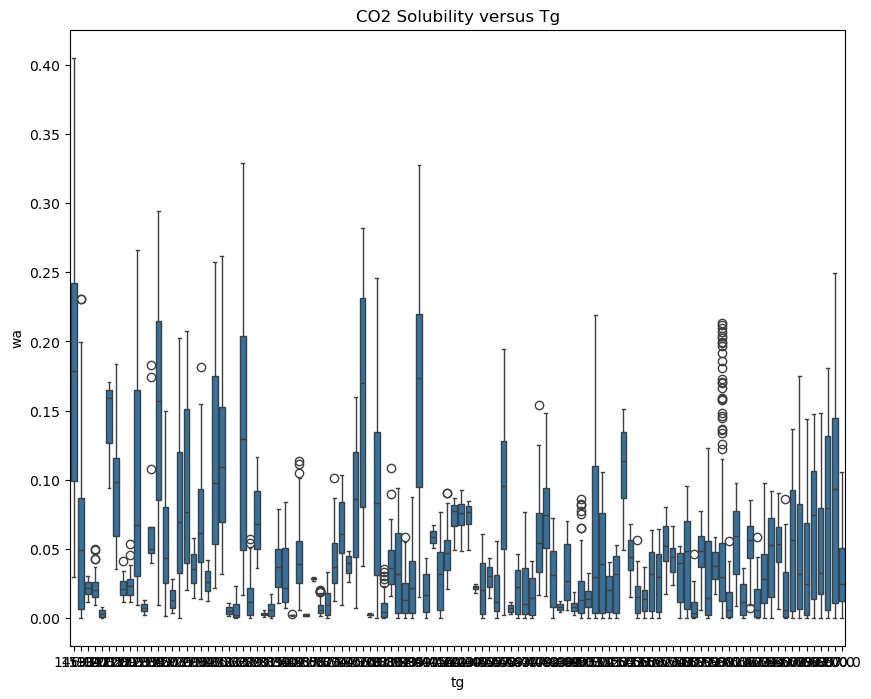

In [17]:
# Tg
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='tg', y='wa')
ax.set_title('CO2 Solubility versus Tg')
plt.show()

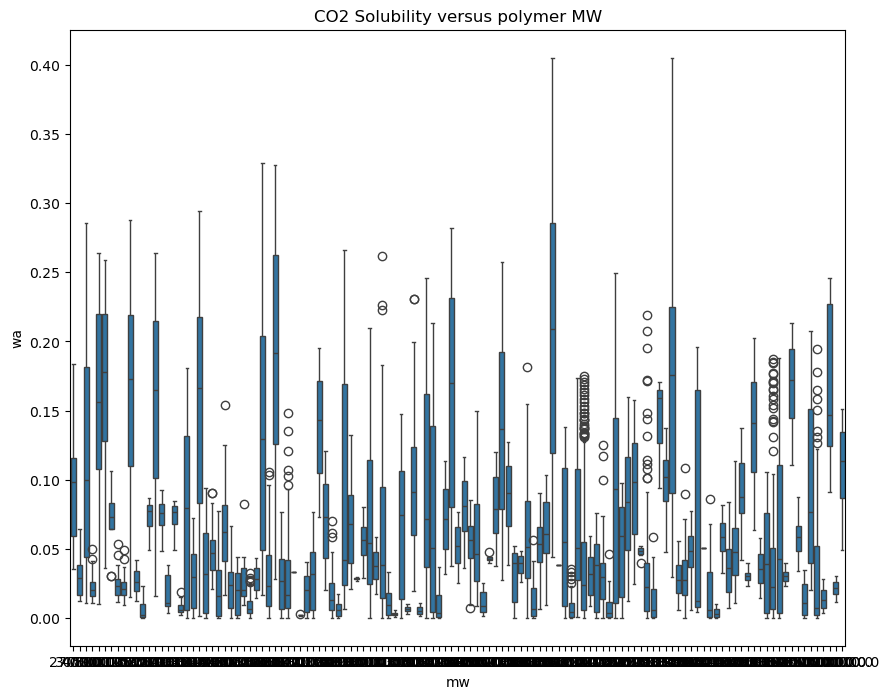

In [18]:
# Pressure
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='mw', y='wa')
ax.set_title('CO2 Solubility versus polymer MW')
plt.show()

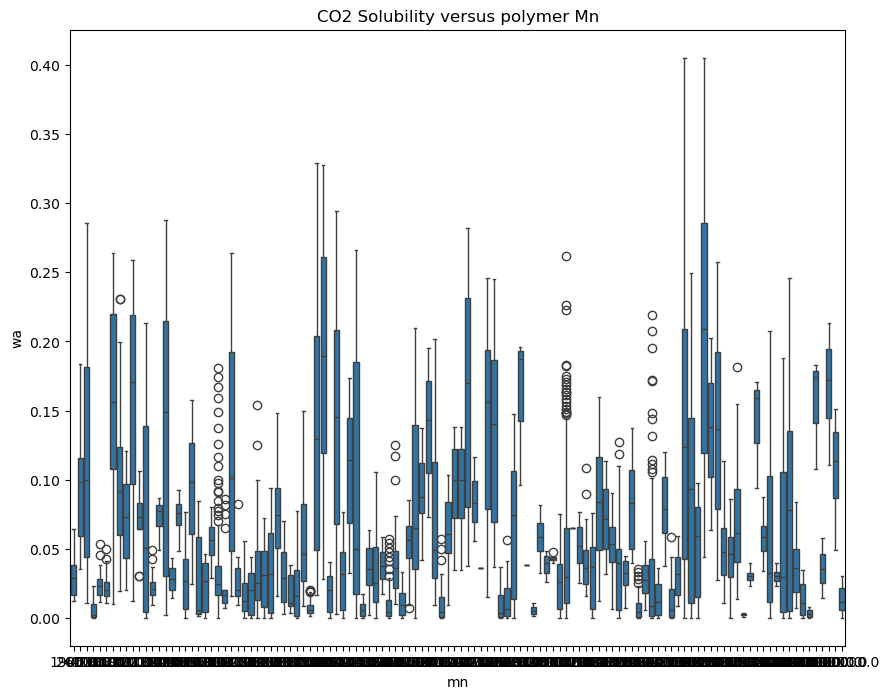

In [19]:
# mn
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='mn', y='wa')
ax.set_title('CO2 Solubility versus polymer Mn')
plt.show()

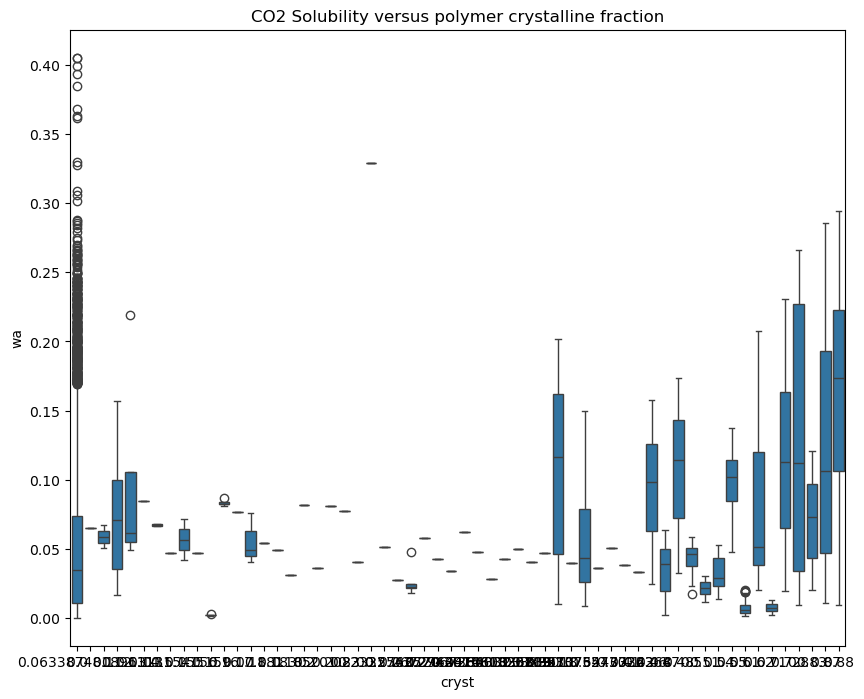

In [20]:
# Crystalline fraction
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='cryst', y='wa')
ax.set_title('CO2 Solubility versus polymer crystalline fraction')
plt.show()

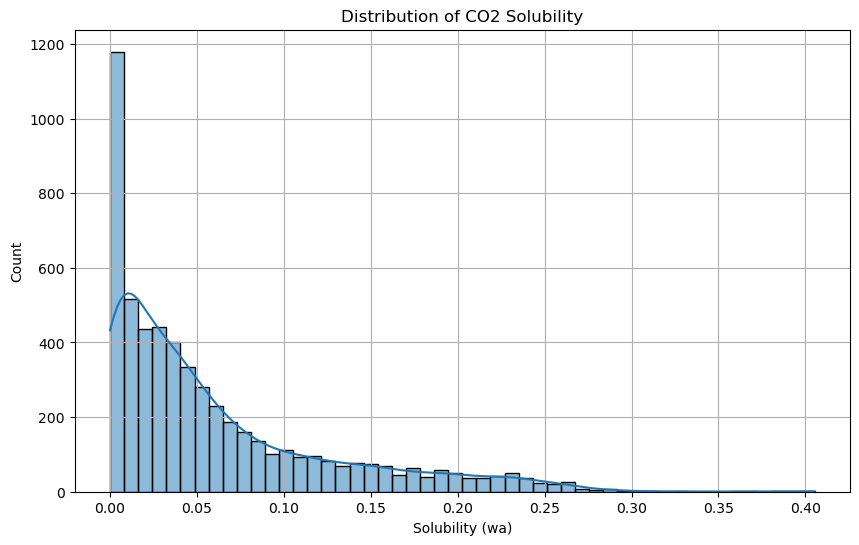

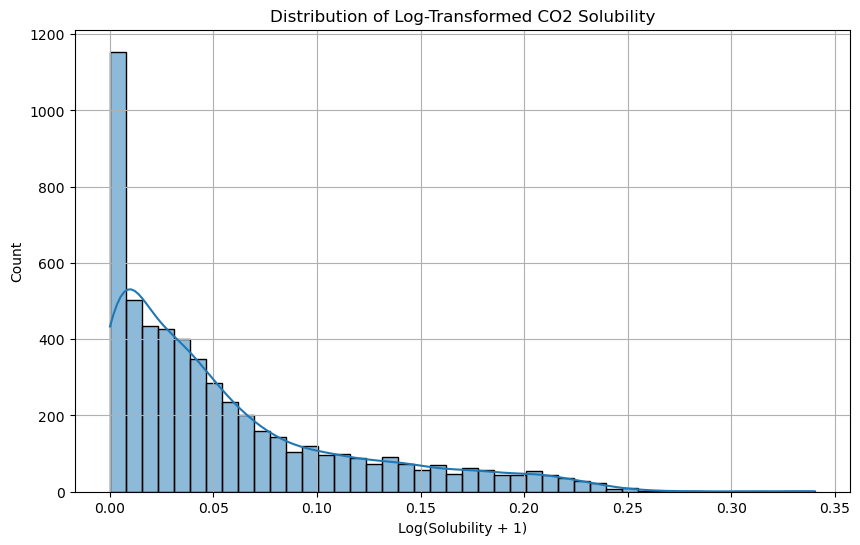

In [21]:
# Distribution of the target variable (solubility)
plt.figure(figsize=(10, 6))
sns.histplot(df_co2['wa'], kde=True)
plt.title('Distribution of CO2 Solubility')
plt.xlabel('Solubility (wa)')
plt.grid(True)
plt.show()

# Log transform if skewed
if df_co2['wa'].skew() > 0.5:
    plt.figure(figsize=(10, 6))
    sns.histplot(np.log1p(df_co2['wa']), kde=True)
    plt.title('Distribution of Log-Transformed CO2 Solubility')
    plt.xlabel('Log(Solubility + 1)')
    plt.grid(True)
    plt.show()

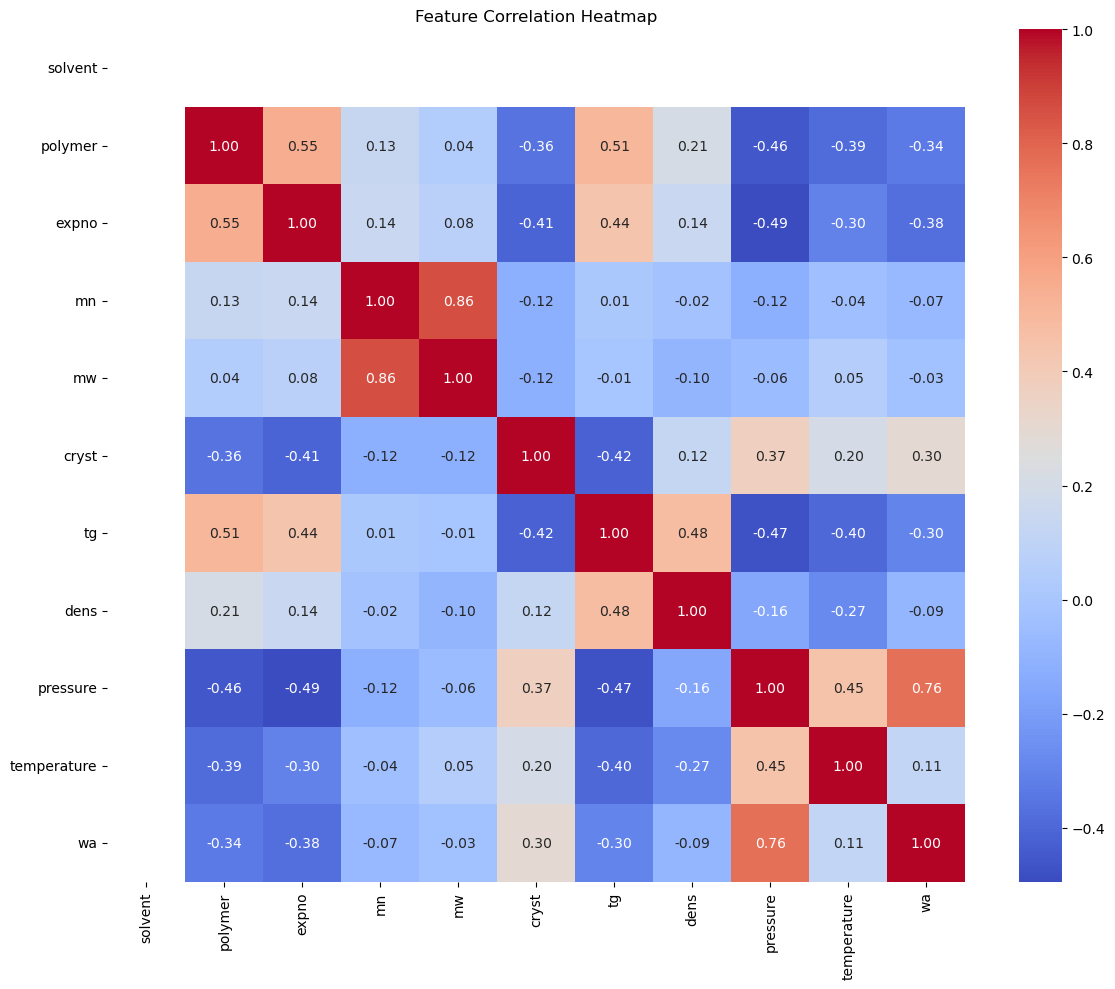

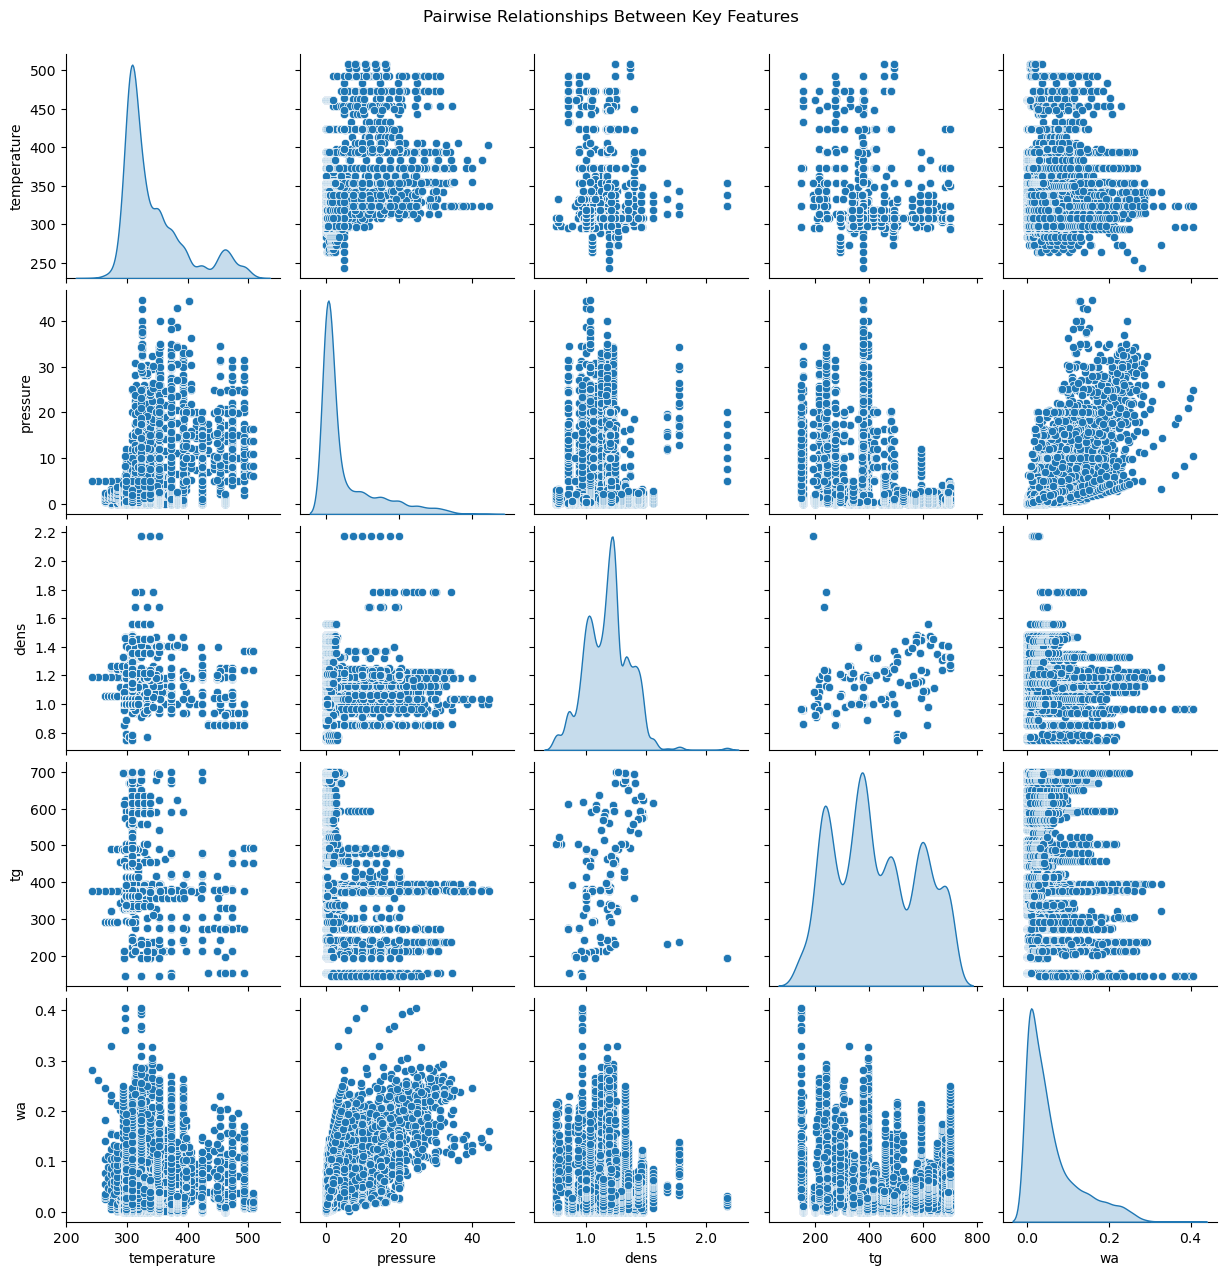

In [21]:
# Correlation heatmap of numeric features
numeric_cols = df_co2.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 10))
correlation = df_co2[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Pairplot for key features
key_features = ['temperature', 'pressure', 'dens', 'tg', 'wa']
sns.pairplot(df_co2[key_features], diag_kind='kde')
plt.suptitle('Pairwise Relationships Between Key Features', y=1.02)
plt.show()

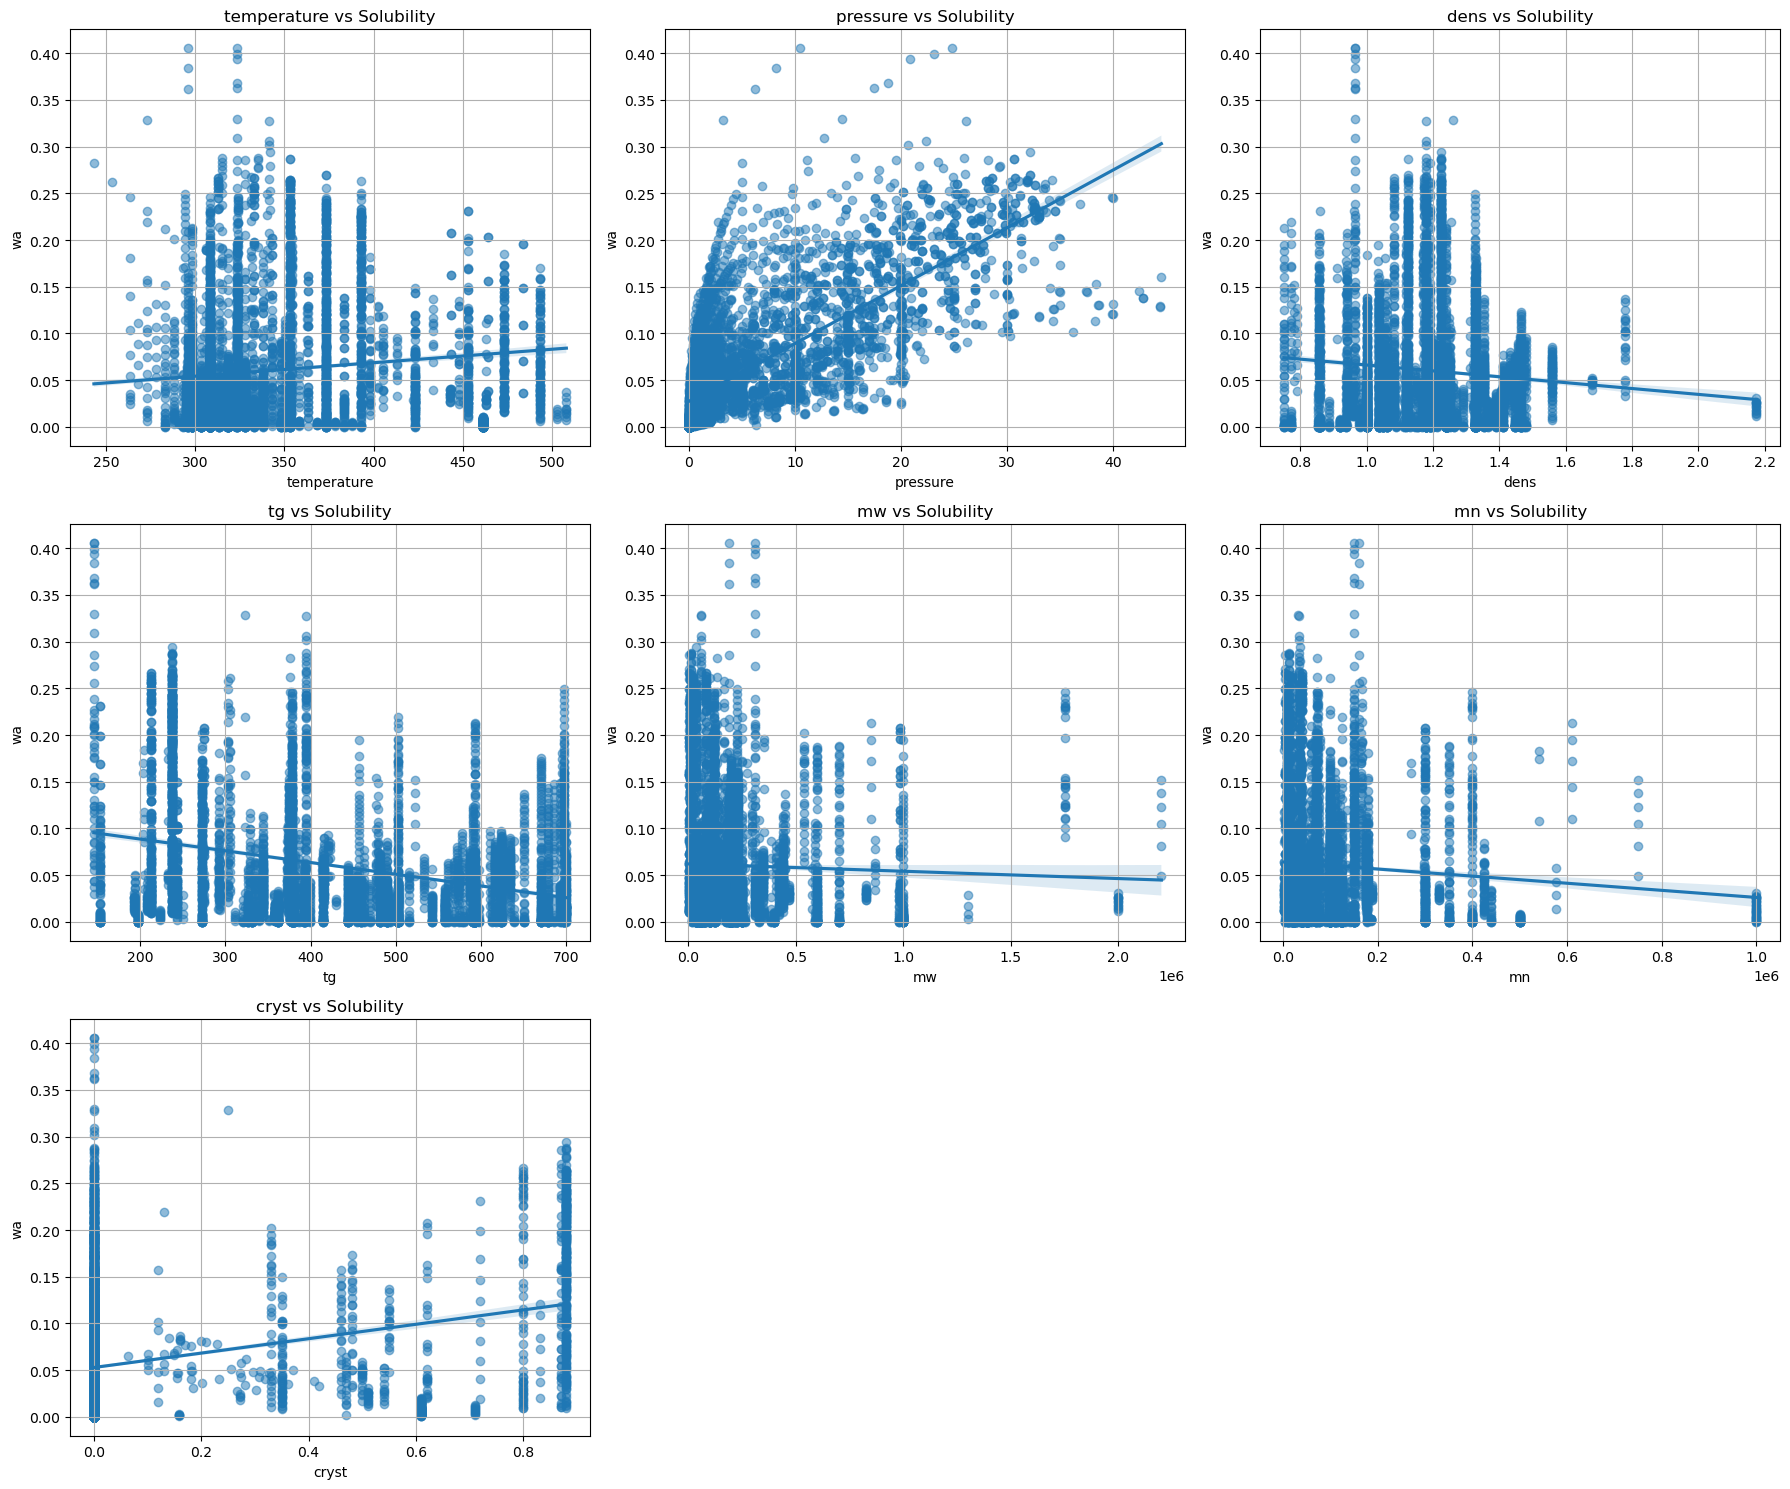

In [32]:
# Scatterplots with regression line for continuous features
features_to_plot = ["temperature", "pressure", "dens", "tg", "mw", "mn", "cryst"]

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    if i < len(axes):
        sns.regplot(x=feature, y='wa', data=df_co2, ax=axes[i], scatter_kws={'alpha':0.5})
        axes[i].set_title(f'{feature} vs Solubility')
        axes[i].grid(True)

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

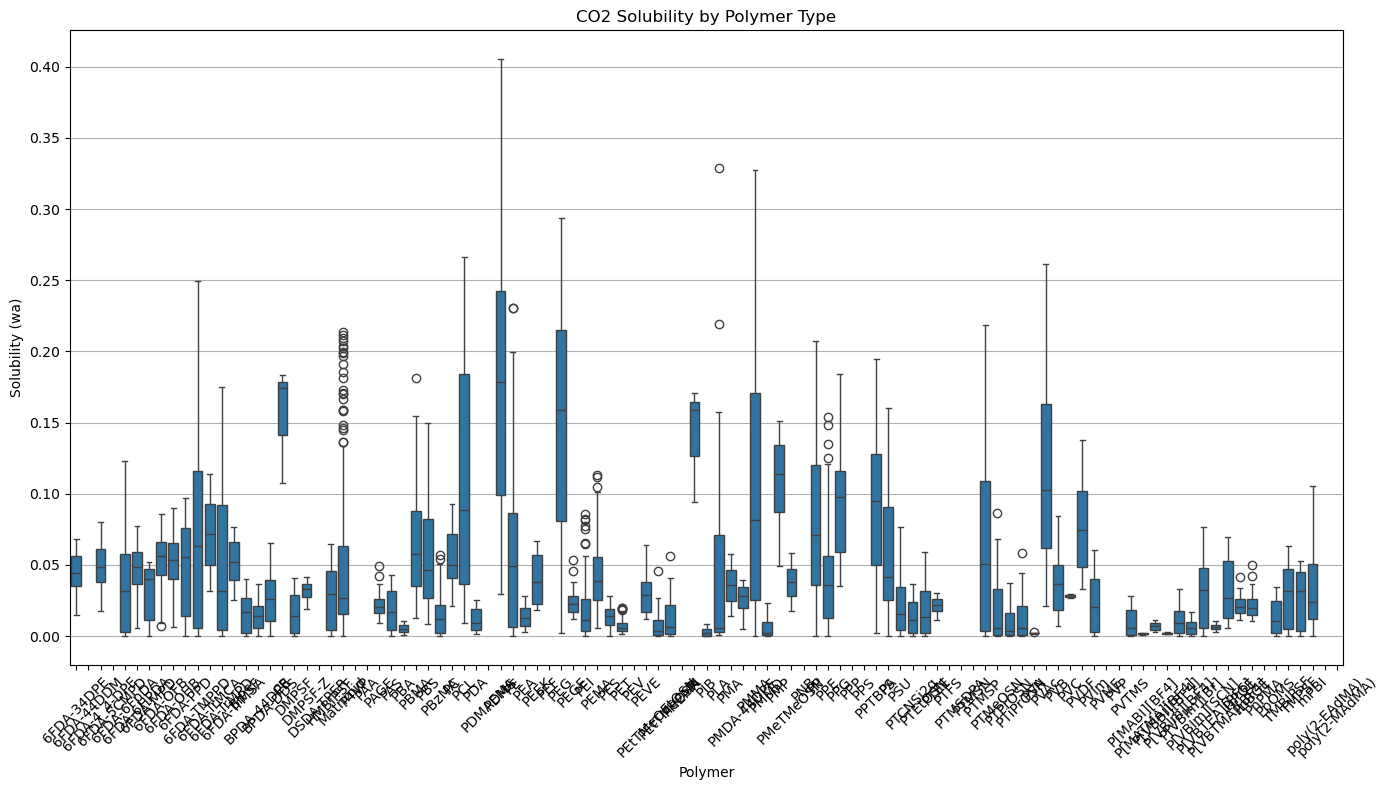

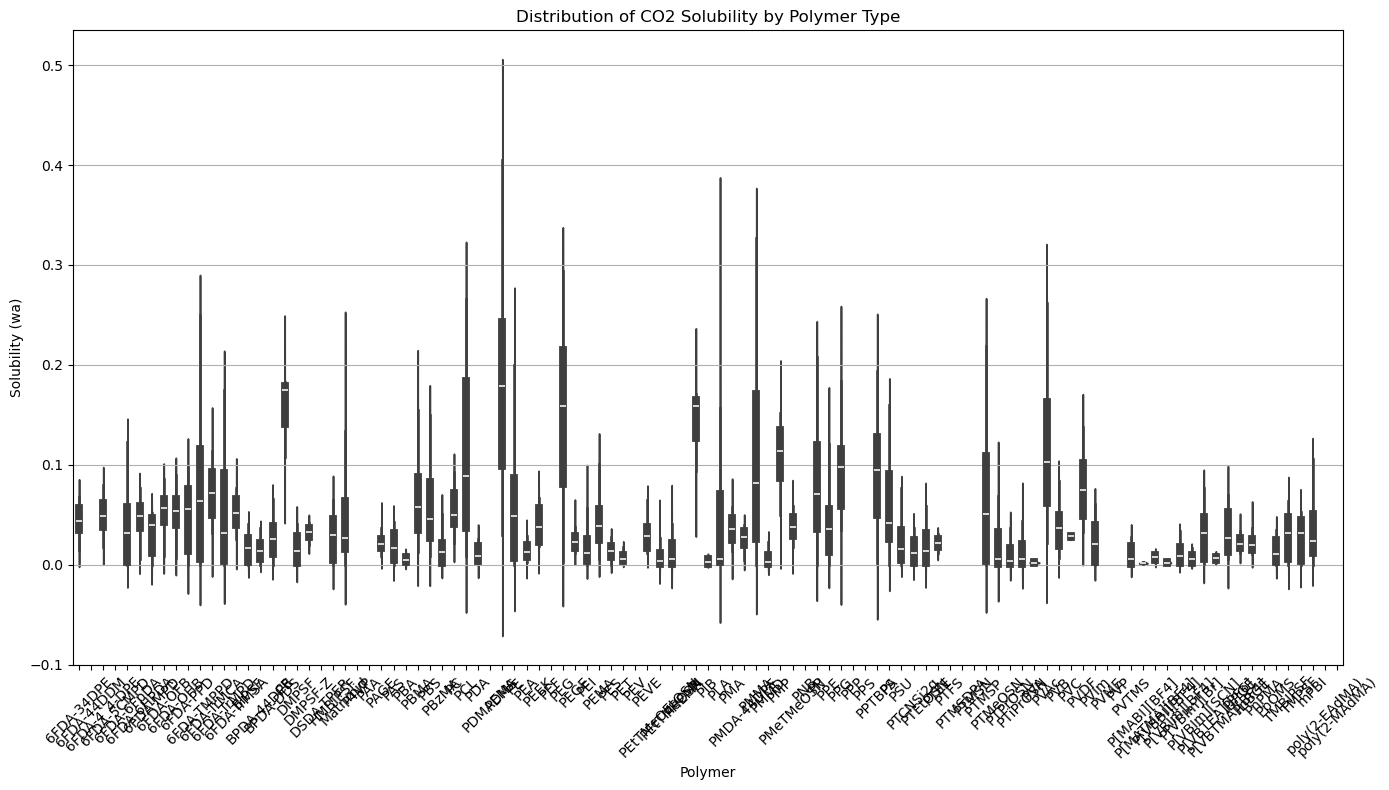

In [33]:
# Boxplot of solubility by polymer type
plt.figure(figsize=(14, 8))
sns.boxplot(x='pol', y='wa', data=df_co2)
plt.xticks(rotation=45)
plt.title('CO2 Solubility by Polymer Type')
plt.xlabel('Polymer')
plt.ylabel('Solubility (wa)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Violin plots to see distribution shapes
plt.figure(figsize=(14, 8))
sns.violinplot(x='pol', y='wa', data=df_co2)
plt.xticks(rotation=45)
plt.title('Distribution of CO2 Solubility by Polymer Type')
plt.xlabel('Polymer')
plt.ylabel('Solubility (wa)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Step 1: `features = ["temperature", "pressure", "dens", "tg", "mw", "mn", "cryst"]`

In [34]:
features = ["temperature", "pressure", "dens", "tg", "mw", "mn", "cryst"]   # features to use
TARGET_COL = 'wa'  # target (solubility)
df_co2_f = df_co2[features + [TARGET_COL]]

num_cols = [c for c in df_co2_f.columns if df_co2[c].dtype != 'object' and c not in ['sol','pol', TARGET_COL]]
cat_cols = [c for c in df_co2_f.columns if df_co2[c].dtype == 'object']

preprocessor = ColumnTransformer([
    ('num', Pipeline([('scaler', StandardScaler())]), num_cols),
    ('cat', Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)])


In [35]:
cat_cols

[]

In [36]:
print("NaN counts in df_co2_f before splitting:")
print(df_co2_f.isnull().sum())

df_co2_f = df_co2_f.dropna()

NaN counts in df_co2_f before splitting:
temperature    0
pressure       0
dens           0
tg             0
mw             0
mn             0
cryst          0
wa             0
dtype: int64


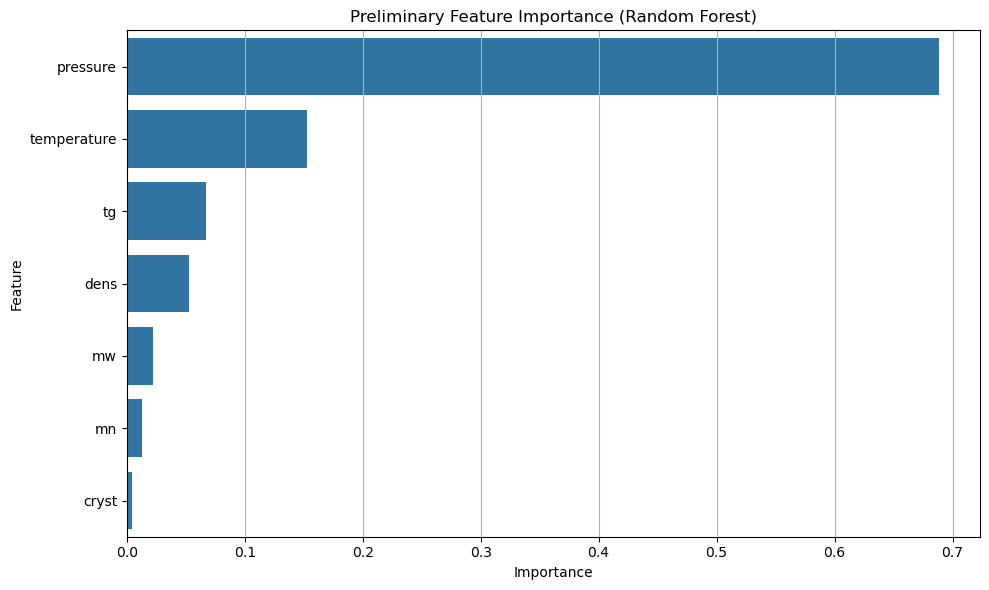

In [37]:
# Simple feature importance visualization using Random Forest
from sklearn.ensemble import RandomForestRegressor

X = df_co2_f.drop(columns=[TARGET_COL])
y = df_co2_f[TARGET_COL]

# Fit a simple Random Forest
rf_prelim = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)
rf_prelim.fit(X, y)

# Plot feature importance
feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_prelim.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance)
plt.title('Preliminary Feature Importance (Random Forest)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

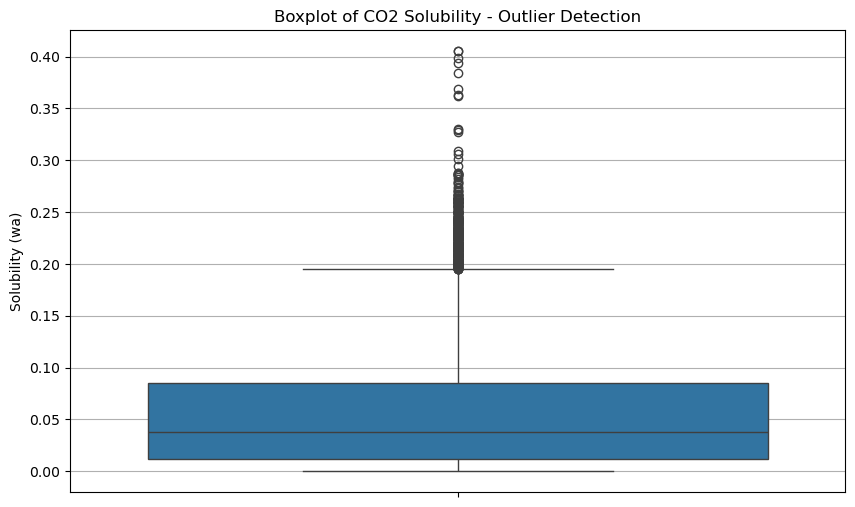

Outliers in temperature: 526 points
  Range: 448.15 to 508.15
Outliers in pressure: 577 points
  Range: 17.9 to 44.5541235255298
Outliers in dens: 33 points
  Range: 1.78 to 2.175
Outliers in tg: 0 points
Outliers in mw: 468 points
  Range: 451000.0 to 2200000.0
Outliers in mn: 473 points
  Range: 271000.0 to 1000000.0
Outliers in cryst: 846 points
  Range: 0.063387481896113 to 0.88


In [39]:
# Boxplot for outlier detection in target variable
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_co2['wa'])
plt.title('Boxplot of CO2 Solubility - Outlier Detection')
plt.ylabel('Solubility (wa)')
plt.grid(True, axis='y')
plt.show()

# IQR method for detecting outliers in features
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers

# Check outliers in key features
for feature in features_to_plot:
    outliers = detect_outliers(df_co2, feature)
    print(f"Outliers in {feature}: {len(outliers)} points")
    if len(outliers) > 0:
        print(f"  Range: {outliers.min()} to {outliers.max()}")

### EDA

C:\Users\sieun\AppData\Local\Temp\ipykernel_30204\1825557204.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


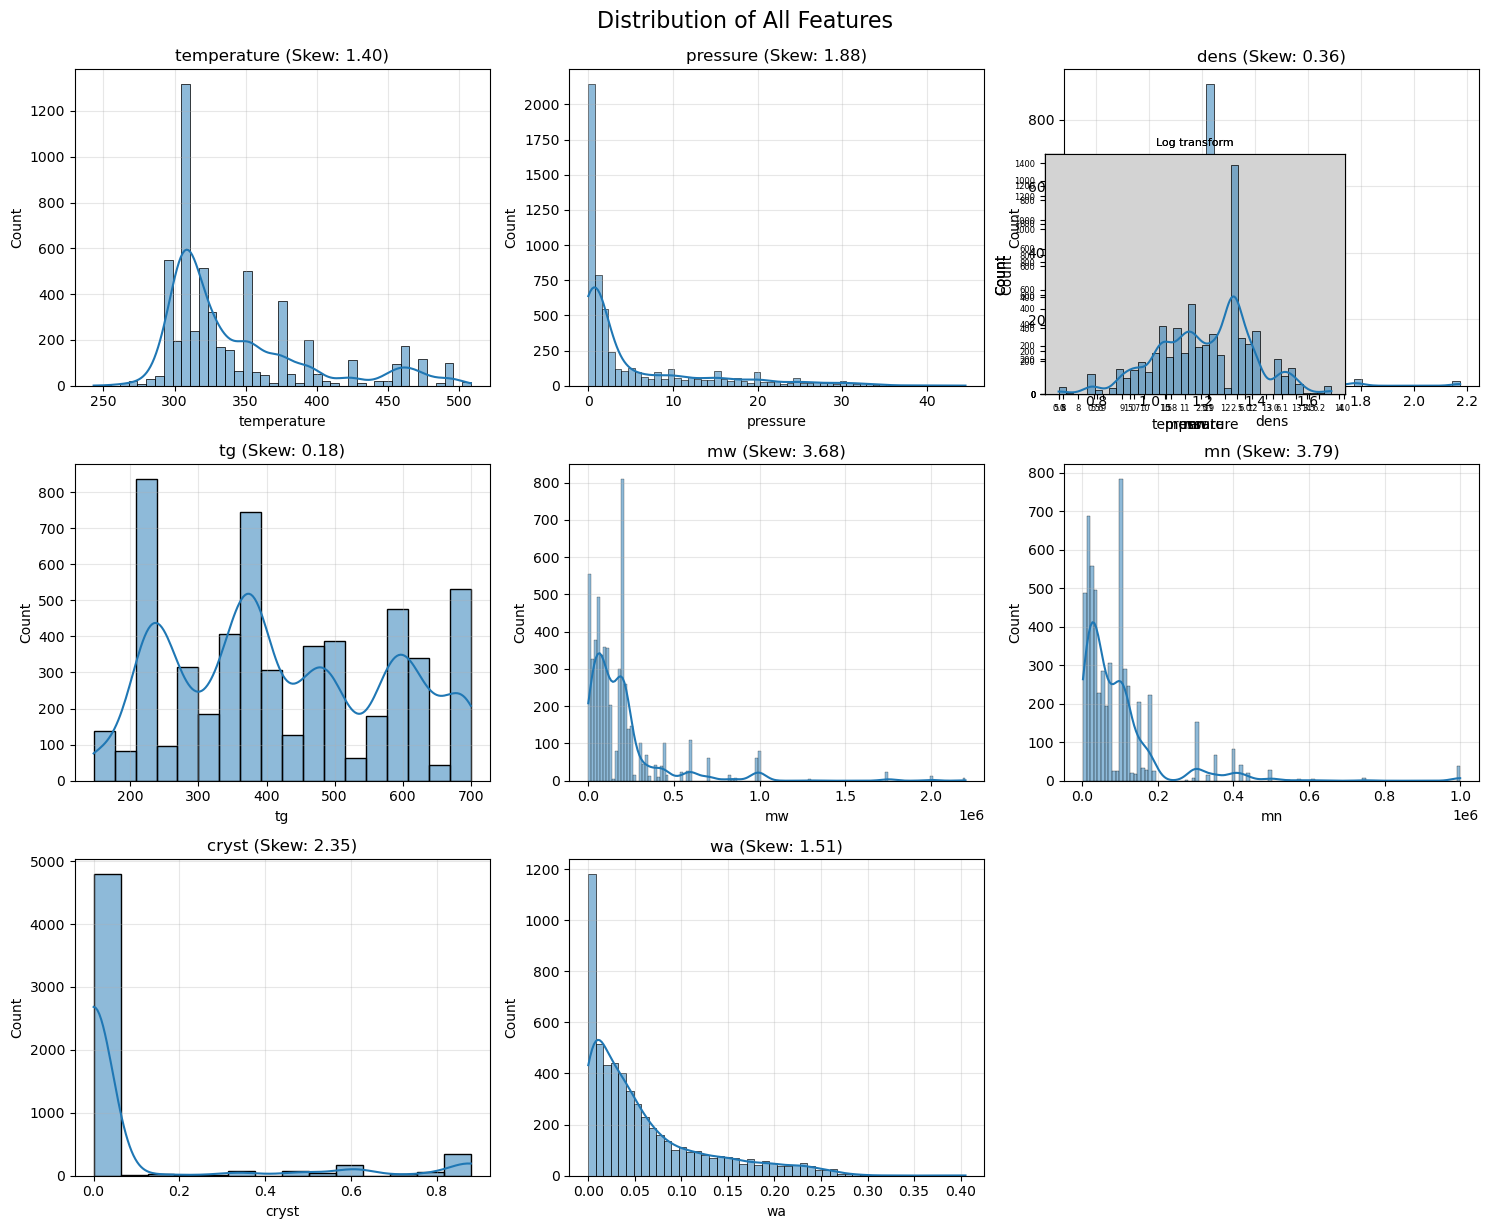

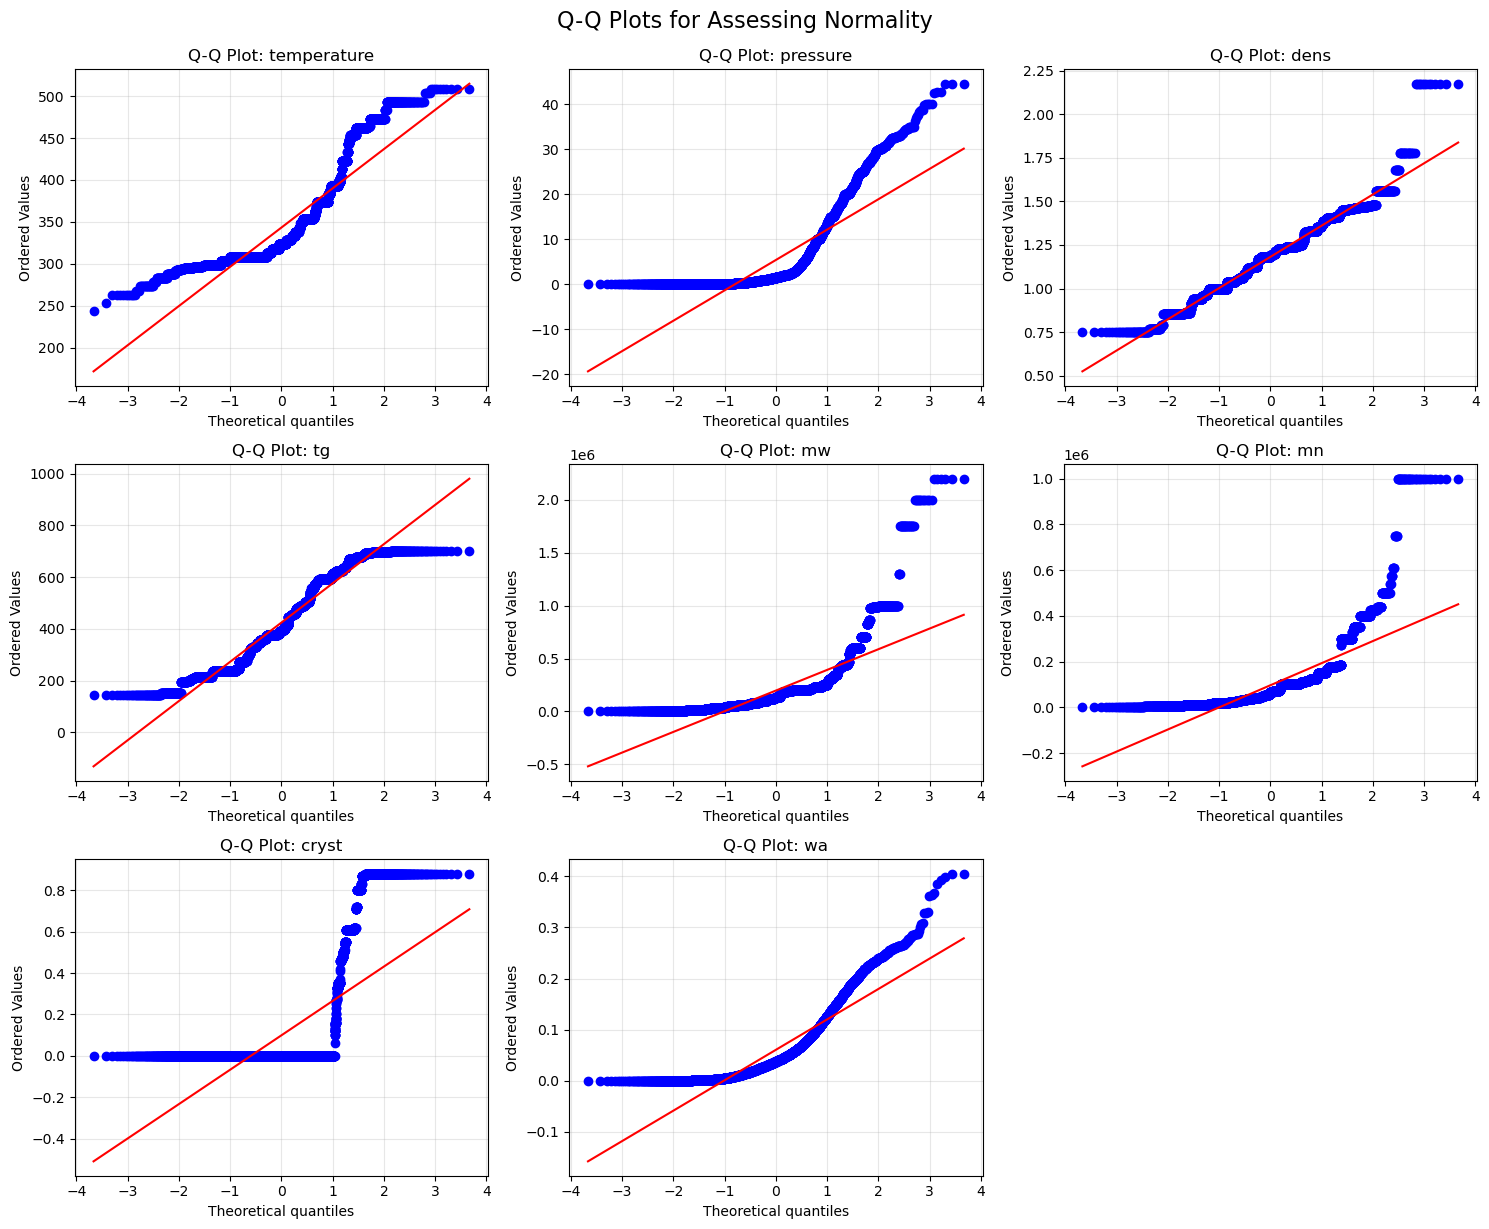

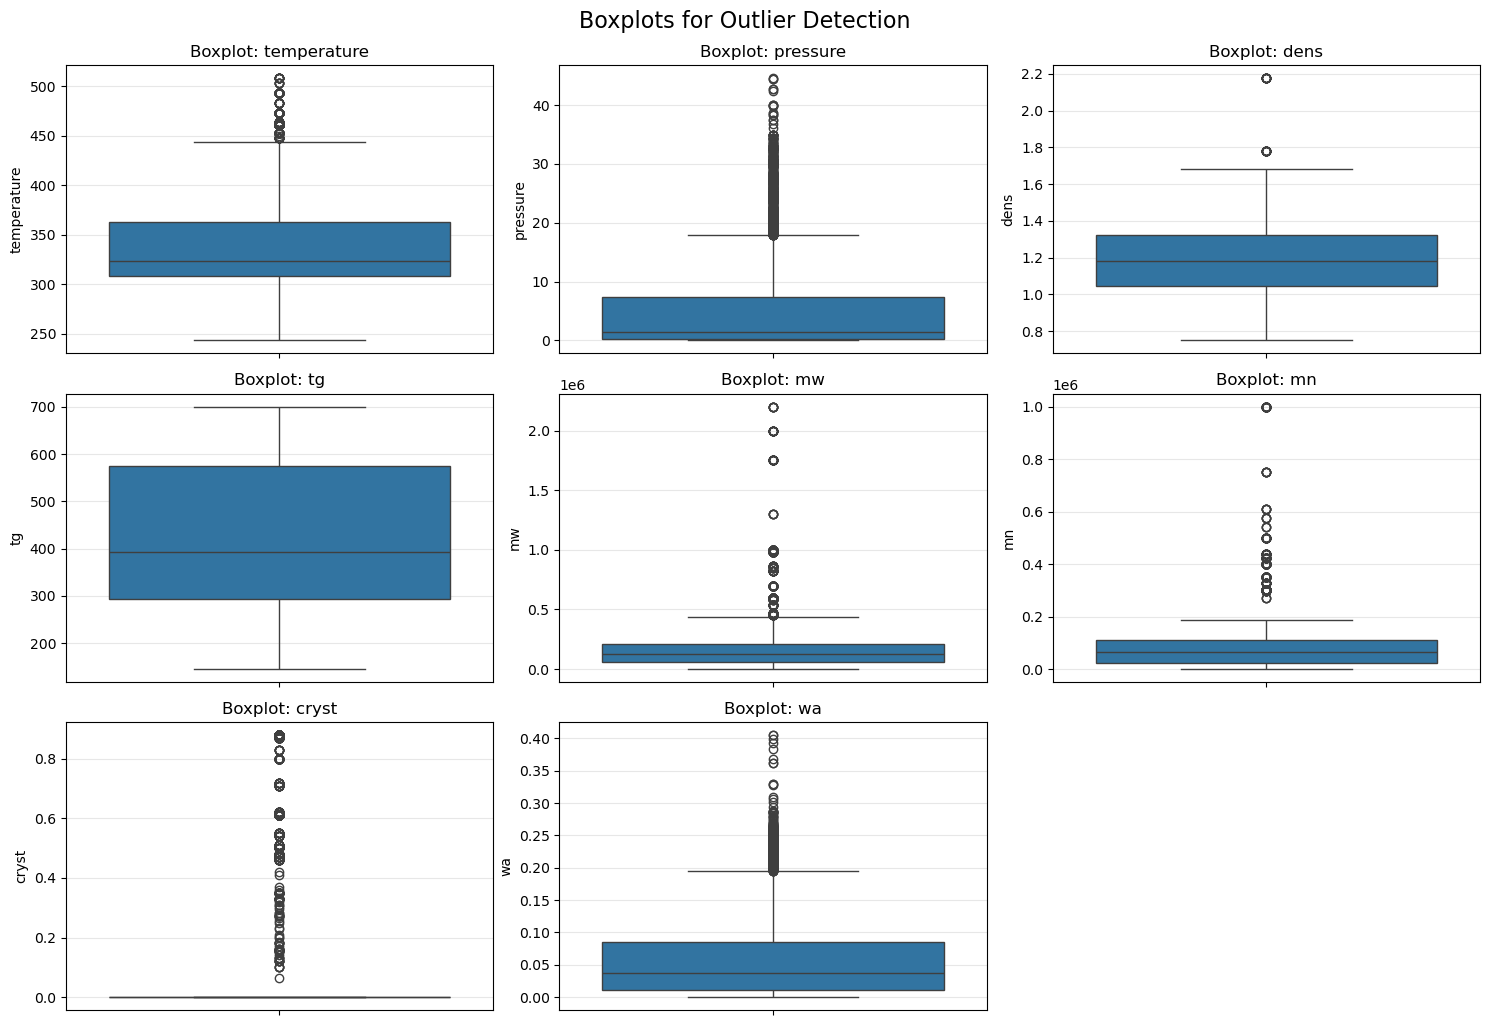

Summary statistics for numerical features:
              count           mean            std        min           25%  \
temperature  5635.0     343.294412      51.658444   243.1500    308.150000   
pressure     5635.0       5.356234       8.090711     0.0001      0.249863   
dens         5635.0       1.181440       0.181321     0.7500      1.046000   
tg           5635.0     424.376868     155.361713   146.0000    293.000000   
mw           5635.0  197140.097604  246533.561363  2700.0000  60000.000000   
mn           5635.0   96441.559795  121822.141337  1900.0000  25000.000000   
cryst        5635.0       0.099346       0.251824     0.0000      0.000000   
wa           5635.0       0.060513       0.065636     0.0001      0.011641   

                       50%            75%           max      skew       kurt  
temperature     323.150000     363.150000  5.081500e+02  1.400271   1.115014  
pressure          1.438819       7.298601  4.455412e+01  1.879111   2.907926  
dens             

In [43]:
# Distribution analysis of all numerical features
plt.figure(figsize=(15, 12))
features_plus_target = features + [TARGET_COL]  # Include target variable
n_features = len(features_plus_target)
rows = (n_features + 1) // 3  # Calculate needed rows for 3 columns

for i, feature in enumerate(features_plus_target):
    plt.subplot(rows, 3, i+1)
    
    # Plot histogram with KDE
    sns.histplot(df_co2_f[feature], kde=True)
    
    # Add skewness value to the plot
    skew = df_co2_f[feature].skew()
    plt.title(f'{feature} (Skew: {skew:.2f})')
    plt.grid(True, alpha=0.3)
    
    # Check if log transformation might help for highly skewed features
    if abs(skew) > 1 and feature != TARGET_COL and df_co2_f[feature].min() > 0:
        # Small subplot for log-transformed version
        ax2 = plt.axes([0.70, 0.70, 0.20, 0.20], facecolor='lightgrey')
        sns.histplot(np.log1p(df_co2_f[feature]), kde=True, ax=ax2)
        ax2.set_title('Log transform', fontsize=8)
        ax2.tick_params(labelsize=6)
        ax2.grid(False)

plt.tight_layout()
plt.suptitle('Distribution of All Features', fontsize=16, y=1.02)
plt.show()

# QQ plots to assess normality
plt.figure(figsize=(15, 12))
for i, feature in enumerate(features_plus_target):
    plt.subplot(rows, 3, i+1)
    stats.probplot(df_co2_f[feature], plot=plt)
    plt.title(f'Q-Q Plot: {feature}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Q-Q Plots for Assessing Normality', fontsize=16, y=1.02)
plt.show()

# Box plots to identify outliers
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_plus_target):
    plt.subplot(rows, 3, i+1)
    sns.boxplot(df_co2_f[feature])
    plt.title(f'Boxplot: {feature}')
    plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.suptitle('Boxplots for Outlier Detection', fontsize=16, y=1.02)
plt.show()

# Summary statistics for features
print("Summary statistics for numerical features:")
stats_df = df_co2_f[features_plus_target].describe().T
stats_df['skew'] = df_co2_f[features_plus_target].skew()
stats_df['kurt'] = df_co2_f[features_plus_target].kurt()
print(stats_df)

# Check for features that might benefit from transformation
print("\nFeatures that might benefit from transformation (|skew| > 1):")
for feature in features:
    skew = df_co2_f[feature].skew()
    if abs(skew) > 1:
        print(f"{feature}: skew = {skew:.2f}")

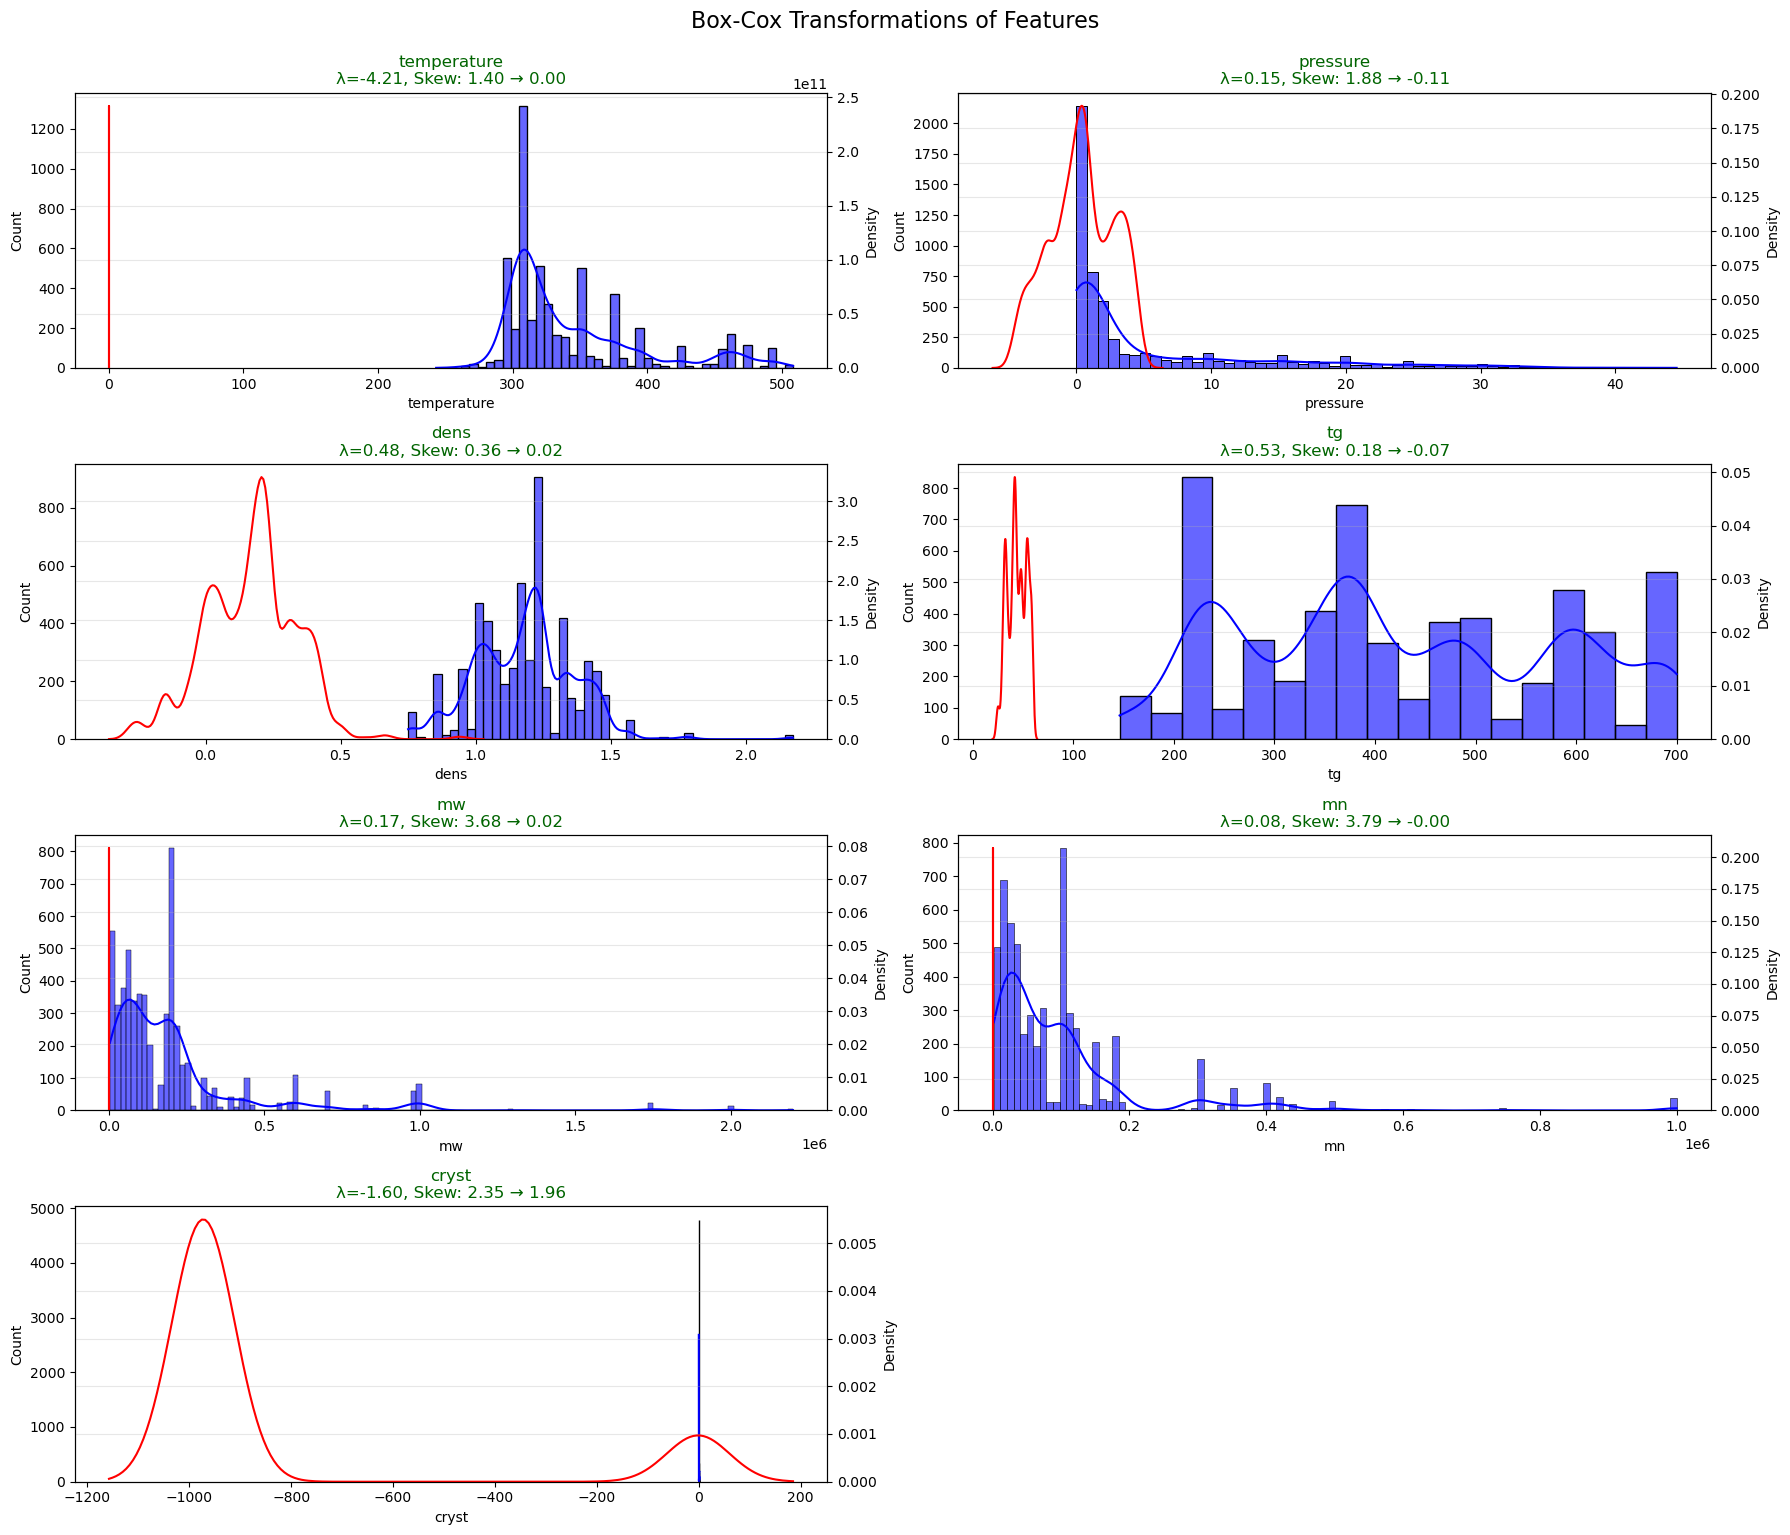

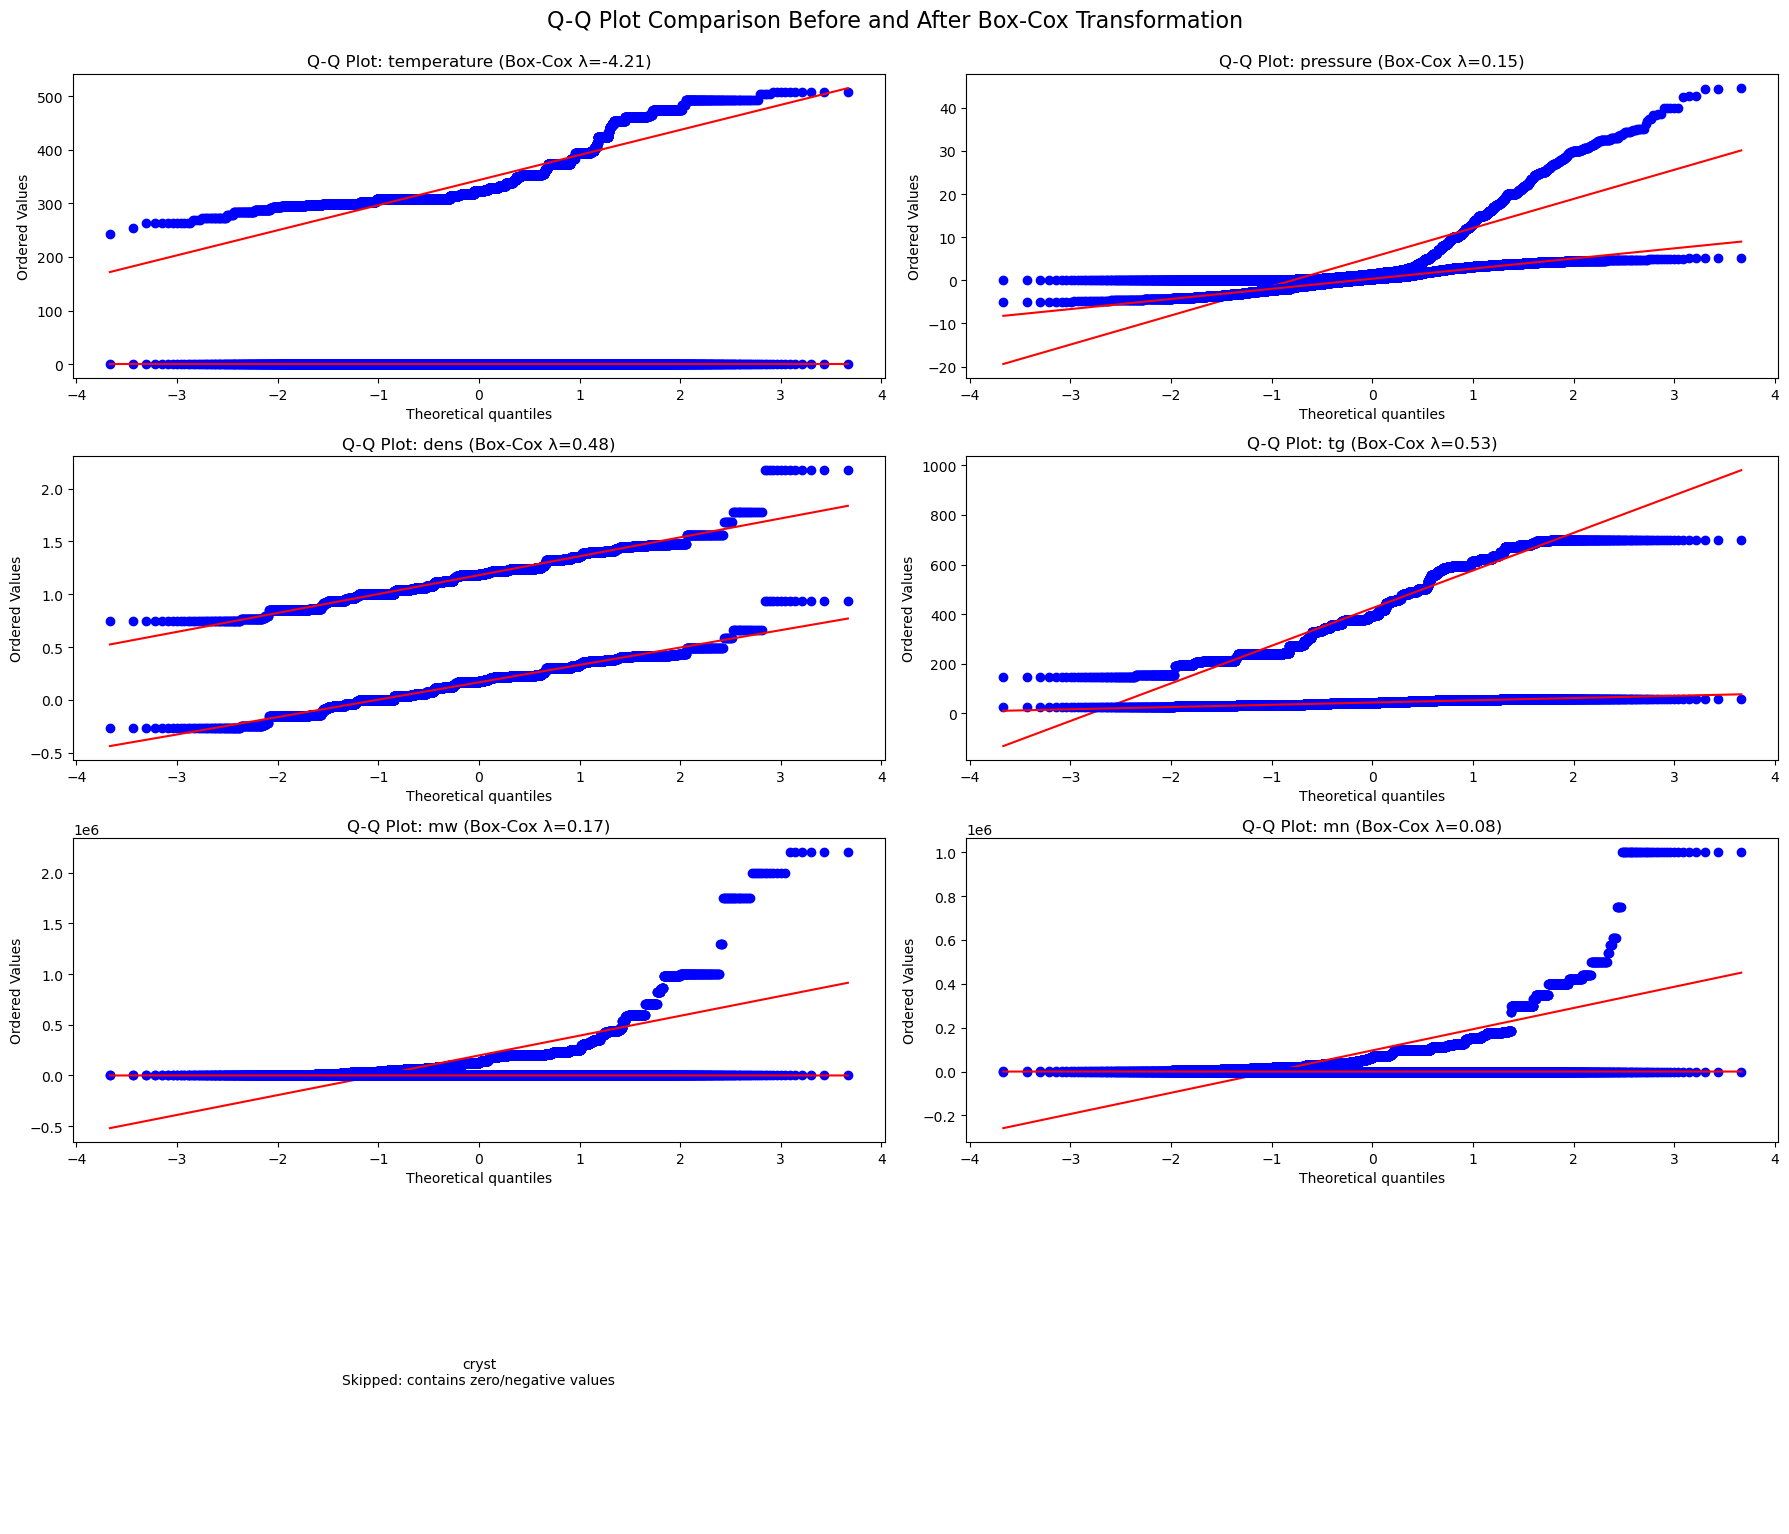


Summary of Box-Cox Transformations:
temperature: λ=-4.2117, Skew: 1.40 → 0.00 (IMPROVED)
pressure: λ=0.1517, Skew: 1.88 → -0.11 (IMPROVED)
dens: λ=0.4778, Skew: 0.36 → 0.02 (IMPROVED)
tg: λ=0.5303, Skew: 0.18 → -0.07 (IMPROVED)
mw: λ=0.1670, Skew: 3.68 → 0.02 (IMPROVED)
mn: λ=0.0772, Skew: 3.79 → -0.00 (IMPROVED)
cryst: Cannot transform (contains zero/negative values). Original skew = 2.35

Recommended features for Box-Cox transformation: ['temperature', 'pressure', 'mw', 'mn']

Target variable 'wa':
  Original skew: 1.51
  Box-Cox λ: 0.2736
  Transformed skew: -0.13
  Recommendation: Consider transforming target


In [44]:
# Automatic Box-Cox transformation and visualization for all features
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Function to apply Box-Cox transform with small constant for zero/negative values
def safe_boxcox(x, eps=0.01):
    # Find minimum value
    x_min = x.min()
    
    # If minimum is <= 0, shift all values
    if x_min <= 0:
        offset = abs(x_min) + eps
        x = x + offset
    
    # Apply Box-Cox
    transformed, lambda_val = stats.boxcox(x)
    return transformed, lambda_val

# Plot original and transformed distributions for all numeric features
plt.figure(figsize=(18, 15))
rows = len(features) // 2 + len(features) % 2
cols = 2

for i, feature in enumerate(features):
    # Get the feature data
    feature_data = df_co2_f[feature].dropna()
    original_skew = feature_data.skew()
    
    # Create subplots for this feature
    plt.subplot(rows, cols, i+1)
    
    # Original distribution with KDE
    sns.histplot(feature_data, kde=True, color='blue', alpha=0.6, label='Original')
    
    try:
        # Apply Box-Cox transformation
        transformed_data, lambda_value = safe_boxcox(feature_data)
        transformed_skew = pd.Series(transformed_data).skew()
        
        # Plot transformed data on same axes with secondary y-axis
        ax2 = plt.twinx()
        sns.kdeplot(transformed_data, color='red', ax=ax2, label='Box-Cox')
        
        # Add transformation info to plot
        plt.title(f'{feature}\nλ={lambda_value:.2f}, Skew: {original_skew:.2f} → {transformed_skew:.2f}')
        
        # Color the title based on improvement
        if abs(transformed_skew) < abs(original_skew):
            plt.title(f'{feature}\nλ={lambda_value:.2f}, Skew: {original_skew:.2f} → {transformed_skew:.2f}', 
                     color='darkgreen')
        else:
            plt.title(f'{feature}\nλ={lambda_value:.2f}, Skew: {original_skew:.2f} → {transformed_skew:.2f}', 
                     color='darkred')
            
    except Exception as e:
        plt.title(f'{feature} (Skew: {original_skew:.2f})\nTransformation failed: {str(e)}')
    
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Box-Cox Transformations of Features', fontsize=16, y=1.02)
plt.show()

# Create visual before/after comparison of Q-Q plots
plt.figure(figsize=(18, 15))

for i, feature in enumerate(features):
    feature_data = df_co2_f[feature].dropna()
    
    # Skip if constant or has non-positive values
    if feature_data.nunique() <= 1 or (feature_data <= 0).any():
        plt.subplot(rows, cols, i+1)
        plt.text(0.5, 0.5, f'{feature}\nSkipped: contains zero/negative values', 
                ha='center', va='center')
        plt.axis('off')
        continue
        
    try:
        # Apply Box-Cox transformation
        transformed_data, lambda_value = stats.boxcox(feature_data)
        
        # Original Q-Q plot
        plt.subplot(rows, cols, i+1)
        stats.probplot(feature_data, plot=plt)
        plt.title(f'Q-Q Plot: {feature} (Original)')
        
        # Transformed Q-Q plot next to it
        plt.subplot(rows, cols, i+1)
        stats.probplot(transformed_data, plot=plt)
        plt.title(f'Q-Q Plot: {feature} (Box-Cox λ={lambda_value:.2f})')
        
    except Exception as e:
        plt.subplot(rows, cols, i+1)
        plt.text(0.5, 0.5, f'Transformation failed: {str(e)}', ha='center', va='center')
        plt.axis('off')

plt.tight_layout()
plt.suptitle('Q-Q Plot Comparison Before and After Box-Cox Transformation', fontsize=16, y=1.02)
plt.show()

# Summary of transformations
print("\nSummary of Box-Cox Transformations:")
transformation_results = {}

for feature in features:
    feature_data = df_co2_f[feature].dropna()
    original_skew = feature_data.skew()
    
    # Skip if there are zero or negative values
    if (feature_data <= 0).any():
        print(f"{feature}: Cannot transform (contains zero/negative values). Original skew = {original_skew:.2f}")
        continue
        
    try:
        # Apply transformation
        transformed_data, lambda_value = stats.boxcox(feature_data)
        transformed_skew = pd.Series(transformed_data).skew()
        
        improvement = abs(transformed_skew) < abs(original_skew)
        status = "IMPROVED" if improvement else "NOT IMPROVED"
        
        print(f"{feature}: λ={lambda_value:.4f}, Skew: {original_skew:.2f} → {transformed_skew:.2f} ({status})")
        
        transformation_results[feature] = {
            'lambda': lambda_value,
            'original_skew': original_skew,
            'transformed_skew': transformed_skew,
            'improved': improvement
        }
        
    except Exception as e:
        print(f"{feature}: Transformation failed - {str(e)}")

# Features to consider for transformation in the modeling pipeline
recommended_transforms = [feature for feature, info in transformation_results.items() 
                         if info['improved'] and abs(info['original_skew']) > 0.5]

print(f"\nRecommended features for Box-Cox transformation: {recommended_transforms}")

# Check target variable specifically if it's positive
if (df_co2_f[TARGET_COL] > 0).all():
    target_data = df_co2_f[TARGET_COL]
    original_skew = target_data.skew()
    
    try:
        transformed_target, target_lambda = stats.boxcox(target_data)
        transformed_skew = pd.Series(transformed_target).skew()
        
        print(f"\nTarget variable '{TARGET_COL}':")
        print(f"  Original skew: {original_skew:.2f}")
        print(f"  Box-Cox λ: {target_lambda:.4f}")
        print(f"  Transformed skew: {transformed_skew:.2f}")
        print(f"  Recommendation: {'Consider transforming target' if abs(transformed_skew) < abs(original_skew) else 'Keep original scale'}")
        
    except Exception as e:
        print(f"\nTarget variable transformation failed: {str(e)}")
else:
    print(f"\nTarget variable '{TARGET_COL}' contains zeros or negative values, Box-Cox not applicable.")

→ Consider 'crys' feature.

In [45]:
# Test model performance with and without 'cryst'
from sklearn.model_selection import cross_val_score

# Define feature sets
features_with_cryst = ["temperature", "pressure", "dens", "tg", "mw", "mn", "cryst"]
features_without_cryst = ["temperature", "pressure", "dens", "tg", "mw", "mn"]

# Test datasets
X_with_cryst = df_co2_f[features_with_cryst]
X_without_cryst = df_co2_f[features_without_cryst]
y = df_co2_f[TARGET_COL]

# Simple model for comparison
model = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=RANDOM_SEED))
])

# Compare performance
with_cryst_scores = cross_val_score(model, X_with_cryst, y, 
                                     scoring='neg_root_mean_squared_error', cv=5)
without_cryst_scores = cross_val_score(model, X_without_cryst, y, 
                                        scoring='neg_root_mean_squared_error', cv=5)

print(f"With 'cryst' RMSE: {-with_cryst_scores.mean():.4f} ± {with_cryst_scores.std():.4f}")
print(f"Without 'cryst' RMSE: {-without_cryst_scores.mean():.4f} ± {without_cryst_scores.std():.4f}")

# Paired t-test to check if difference is significant
from scipy import stats
t_stat, p_value = stats.ttest_rel(with_cryst_scores, without_cryst_scores)
print(f"P-value: {p_value:.4f} - {'Significant' if p_value < 0.05 else 'Not significant'} difference")

With 'cryst' RMSE: 0.0350 ± 0.0085
Without 'cryst' RMSE: 0.0345 ± 0.0094
P-value: 0.8417 - Not significant difference


- Analysis: no significant difference with or without `cryst`. 
- Action: Remove `cryst`.

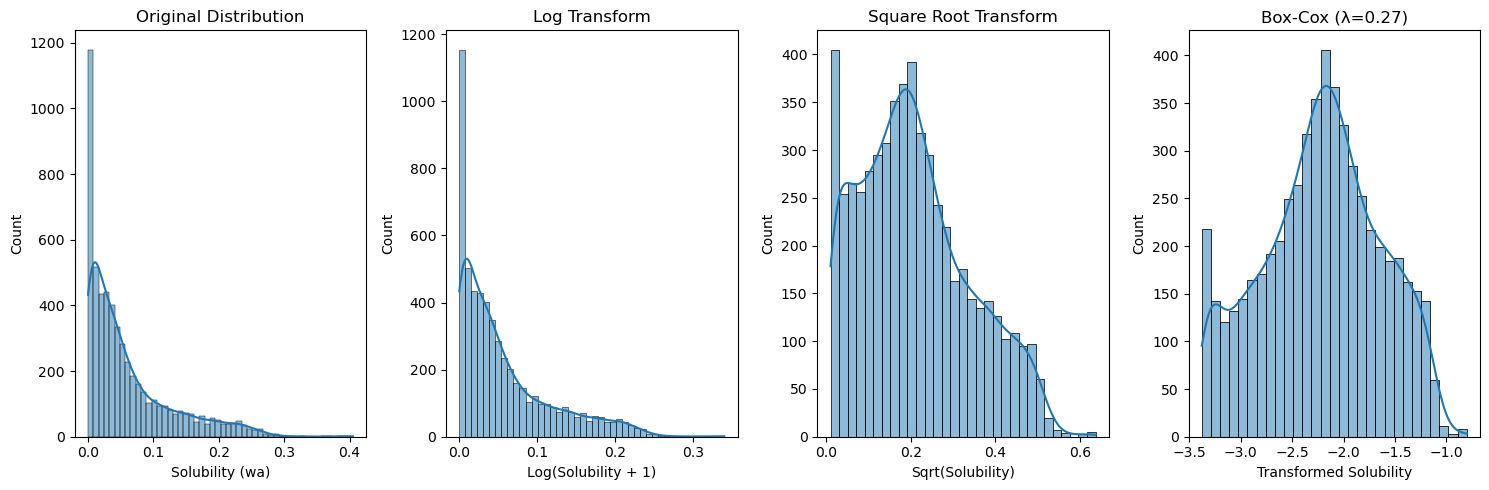

Box-Cox lambda: 0.2652


In [41]:
# Try different transformations
plt.figure(figsize=(15, 5))

# Original data
plt.subplot(1, 4, 1)
sns.histplot(df_co2_f['wa'], kde=True)
plt.title('Original Distribution')
plt.xlabel('Solubility (wa)')

# Log transform
plt.subplot(1, 4, 2)
sns.histplot(np.log1p(df_co2_f['wa']), kde=True)
plt.title('Log Transform')
plt.xlabel('Log(Solubility + 1)')

# Square root transform
plt.subplot(1, 4, 3)
sns.histplot(np.sqrt(df_co2_f['wa']), kde=True)
plt.title('Square Root Transform')
plt.xlabel('Sqrt(Solubility)')

# Box-Cox transform
from scipy import stats
transformed_data, lambda_value = stats.boxcox(df_co2_f['wa'] + 0.0001)  # Adding small constant to handle zeros
plt.subplot(1, 4, 4)
sns.histplot(transformed_data, kde=True)
plt.title(f'Box-Cox (λ={lambda_value:.2f})')
plt.xlabel('Transformed Solubility')

plt.tight_layout()
plt.show()
print(f"Box-Cox lambda: {lambda_value:.4f}")

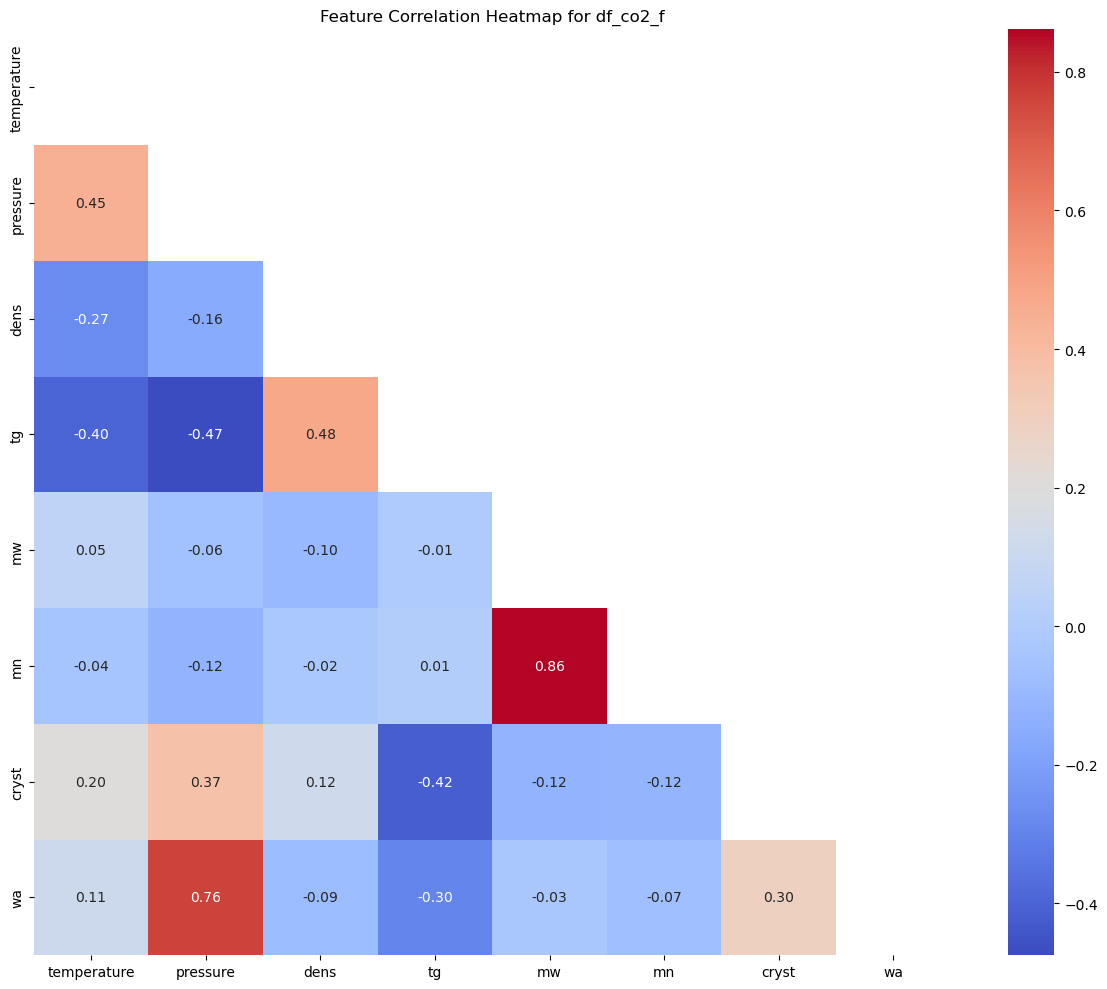

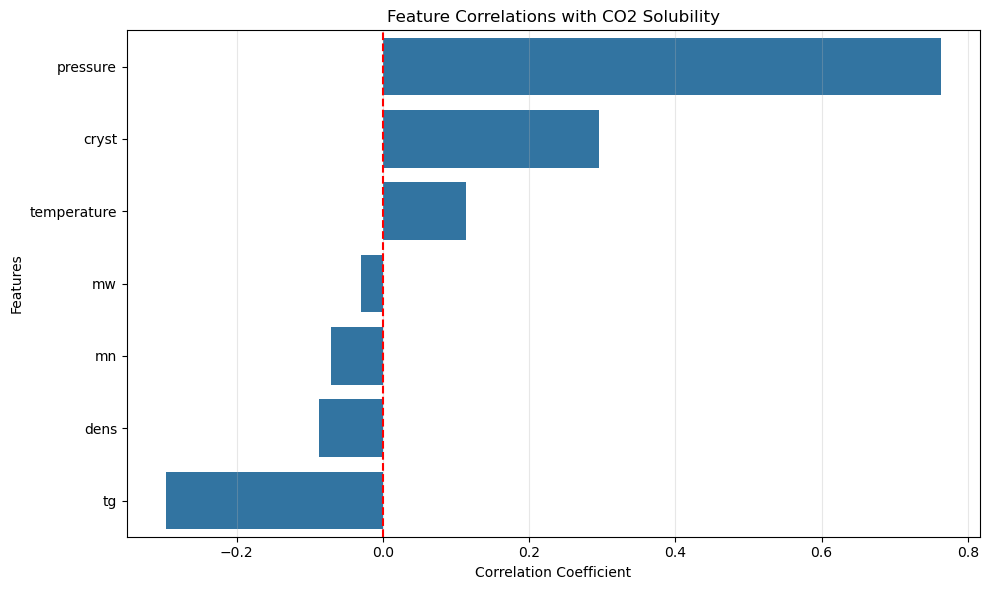

Features sorted by absolute correlation with CO2 solubility:
pressure       0.762928
tg             0.297122
cryst          0.295762
temperature    0.113422
dens           0.086800
mn             0.070553
mw             0.029453
Name: wa, dtype: float64

Feature pairs with strong correlations (above 0.7):
mn & mw: 0.861
wa & pressure: 0.763


In [42]:
# Correlation analysis for df_co2_f
plt.figure(figsize=(12, 10))
correlation = df_co2_f.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))  # Create upper triangle mask
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Feature Correlation Heatmap for df_co2_f')
plt.tight_layout()
plt.show()

# Calculate and display correlation with target
target_corr = correlation[TARGET_COL].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.values[1:], y=target_corr.index[1:])  # Exclude the target's correlation with itself
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Feature Correlations with CO2 Solubility')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print sorted correlations with target
print("Features sorted by absolute correlation with CO2 solubility:")
print(target_corr[1:].abs().sort_values(ascending=False))

# Identify multicollinearity between features
print("\nFeature pairs with strong correlations (above 0.7):")
for i in range(len(correlation.columns)):
    for j in range(i):
        if abs(correlation.iloc[i, j]) > 0.7 and i != j:
            print(f"{correlation.columns[i]} & {correlation.columns[j]}: {correlation.iloc[i, j]:.3f}")

- Analysis: `Mw` is highly correlated to `Mn`.
- Action: remove `Mn`.

# Preprocessing

In [46]:
# Comprehensive preprocessing pipeline with transformations, outlier removal and scaling
import numpy as np
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.impute import SimpleImputer

# 1. Custom transformer for outlier removal
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.5):
        self.threshold = threshold
        self.feature_bounds = {}
        
    def fit(self, X, y=None):
        # Calculate IQR bounds for each feature
        for col in X.columns:
            Q1 = np.percentile(X[col], 25)
            Q3 = np.percentile(X[col], 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - self.threshold * IQR
            upper_bound = Q3 + self.threshold * IQR
            self.feature_bounds[col] = (lower_bound, upper_bound)
        return self
    
    def transform(self, X):
        X_clean = X.copy()
        for col, (lower, upper) in self.feature_bounds.items():
            # Clip values to bounds instead of removing rows
            X_clean[col] = np.clip(X_clean[col], lower, upper)
        return X_clean

# 2. Custom transformer for Box-Cox or other transformations
class FeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, method='boxcox'):
        self.method = method
        self.lambdas = {}
        self.shifts = {}
        
    def fit(self, X, y=None):
        # Find optimal lambda for each feature that needs transformation
        for col in X.columns:
            data = X[col].values
            # Shift data if it contains zero or negative values
            min_val = np.min(data)
            shift = 0
            if min_val <= 0:
                shift = abs(min_val) + 0.01
                data = data + shift
                self.shifts[col] = shift
            
            if self.method == 'boxcox':
                # Apply Box-Cox and find optimal lambda
                try:
                    transformed_data, lambda_val = stats.boxcox(data)
                    self.lambdas[col] = lambda_val
                except:
                    # If Box-Cox fails, use log transformation
                    self.lambdas[col] = 0  # lambda=0 is equivalent to log transform
                    
            elif self.method == 'log':
                self.lambdas[col] = 0  # Just for consistency
                
            elif self.method == 'sqrt':
                self.lambdas[col] = 0.5  # Just for consistency
                
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        for col in X.columns:
            data = X[col].values
            
            # Apply shift if needed
            if col in self.shifts:
                data = data + self.shifts[col]
            
            # Apply transformation based on method
            if self.method == 'boxcox' and col in self.lambdas:
                lambda_val = self.lambdas[col]
                if lambda_val == 0:
                    X_transformed[col] = np.log(data)
                else:
                    X_transformed[col] = (data ** lambda_val - 1) / lambda_val
                    
            elif self.method == 'log':
                X_transformed[col] = np.log1p(data)  # log(1+x) to handle zeros
                
            elif self.method == 'sqrt':
                X_transformed[col] = np.sqrt(data)
                
        return X_transformed

# 3. Create the preprocessing pipeline with transformers that need to be applied to specific columns
def build_preprocessing_pipeline(numeric_features, categorical_features=None, target_col=None,
                               transform_features=None, transform_method='boxcox',
                               remove_outliers=True):
    """
    Build a comprehensive preprocessing pipeline
    
    Parameters:
    -----------
    numeric_features : list
        List of numeric feature names
    categorical_features : list or None
        List of categorical feature names
    target_col : str or None
        Name of target column
    transform_features : list or None
        Features that need to be transformed with Box-Cox or other methods
    transform_method : str, default='boxcox'
        Transformation method ('boxcox', 'log', 'sqrt')
    remove_outliers : bool, default=True
        Whether to remove outliers
        
    Returns:
    --------
    pipeline : ColumnTransformer
        Preprocessing pipeline
    """
    # Initialize the numeric pipeline components
    numeric_pipeline_steps = []
    
    # 1. Remove outliers if needed
    if remove_outliers:
        numeric_pipeline_steps.append(('outlier_remover', OutlierRemover()))
    
    # 2. Handle missing values
    numeric_pipeline_steps.append(('imputer', SimpleImputer(strategy='median')))
    
    # 3. Apply transformations if needed
    if transform_features and len(transform_features) > 0:
        # Only apply transformers to specified features
        transform_indices = [numeric_features.index(f) for f in transform_features 
                           if f in numeric_features]
        
        if transform_indices:
            def select_features(X, indices=transform_indices):
                if isinstance(X, pd.DataFrame):
                    return X.iloc[:, indices]
                return X[:, indices]
                
            def restore_features(X_transformed, X_original, indices=transform_indices):
                if isinstance(X_original, pd.DataFrame):
                    X_out = X_original.copy()
                    for i, idx in enumerate(indices):
                        X_out.iloc[:, idx] = X_transformed[:, i]
                else:
                    X_out = X_original.copy()
                    for i, idx in enumerate(indices):
                        X_out[:, idx] = X_transformed[:, i]
                return X_out
            
            # Compose the transformation
            transform_pipe = Pipeline([
                ('selector', FunctionTransformer(select_features)),
                ('transformer', FeatureTransformer(method=transform_method)),
                ('restorer', FunctionTransformer(restore_features))
            ])
            
            numeric_pipeline_steps.append(('feature_transformer', transform_pipe))
    
    # 4. Apply scaling
    numeric_pipeline_steps.append(('scaler', StandardScaler()))
    
    # Create the numeric pipeline
    numeric_pipeline = Pipeline(numeric_pipeline_steps)
    
    # Create transformer list
    transformers = [('num', numeric_pipeline, numeric_features)]
    
    # Add categorical features if needed
    if categorical_features and len(categorical_features) > 0:
        cat_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        transformers.append(('cat', cat_pipeline, categorical_features))
    
    # Create the combined column transformer
    preprocessor = ColumnTransformer(transformers)
    
    return preprocessor


Dataset shape: (5635, 6)
NaN values: 
temperature    0
pressure       0
dens           0
tg             0
mw             0
wa             0
dtype: int64
Dataset shape after dropping NaNs: (5635, 6)
Outliers in temperature: 526 points
  Range: 448.15 to 508.15
Outliers in pressure: 577 points
  Range: 17.9 to 44.5541235255298
Outliers in dens: 33 points
  Range: 1.78 to 2.175
Outliers in tg: 0 points
Outliers in mw: 468 points
  Range: 451000.0 to 2200000.0
Outliers in temperature after clipping: 0 points
Outliers in pressure after clipping: 0 points
Outliers in dens after clipping: 0 points
Outliers in tg after clipping: 0 points
Outliers in mw after clipping: 0 points
Transformed temperature: λ=-4.0125, Skew: 1.12 → 0.00
Transformed pressure: λ=0.1724, Skew: 1.26 → -0.15
Transformed dens: λ=0.8692, Skew: 0.05 → -0.00


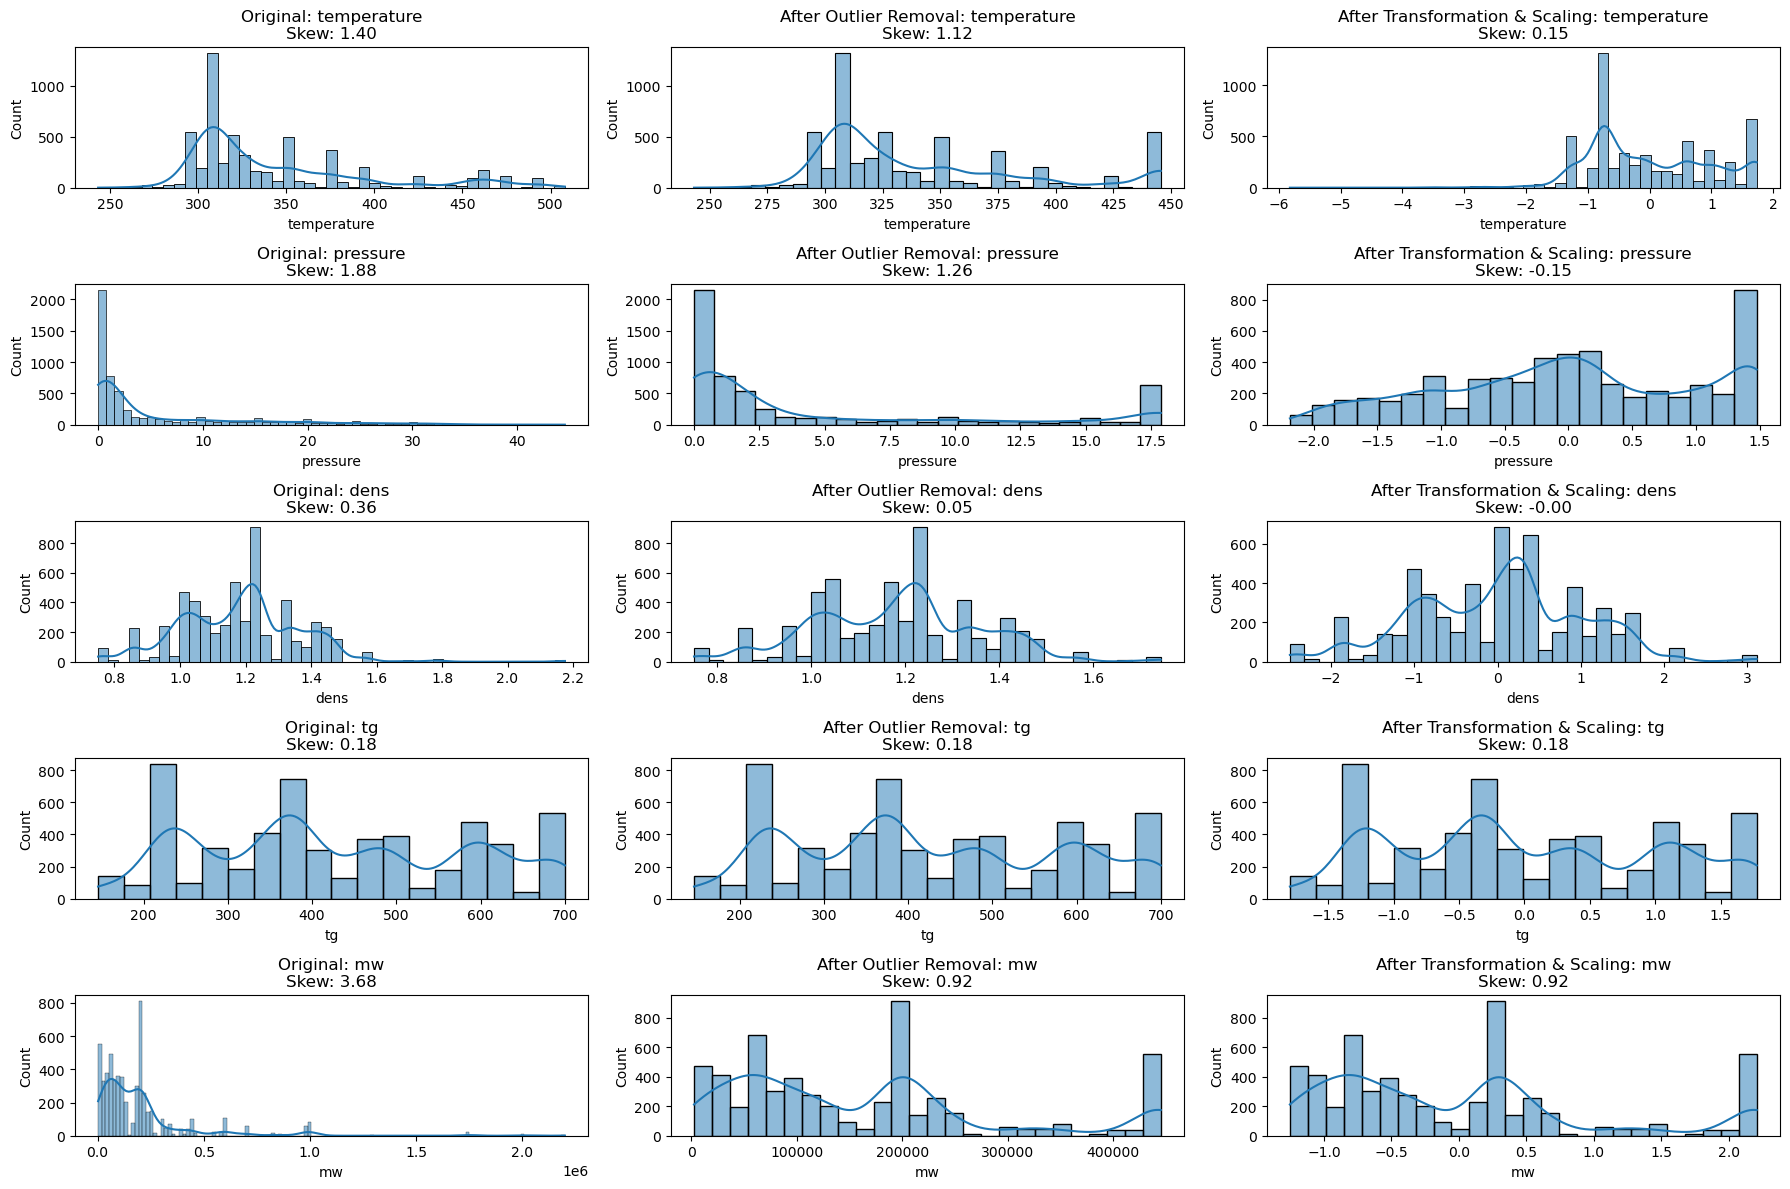

Data preprocessing complete!
Final dataset shape: X: (5635, 5), y: (5635,)


In [ ]:
# Apply transformations, outlier removal and scaling - step by step approach
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define our feature set (without 'cryst' based on your previous analysis)
features = ["temperature", "pressure", "dens", "tg", "mw"]
TARGET_COL = 'wa'

# Step 2: Create a working copy of the dataset
df_work = df_co2[features + [TARGET_COL]].copy()
print(f"Dataset shape: {df_work.shape}")
print(f"NaN values: \n{df_work.isnull().sum()}")

# Step 3: Handle missing values
df_work = df_work.dropna()
print(f"Dataset shape after dropping NaNs: {df_work.shape}")

# Step 4: Identify outliers using the IQR method
outliers_by_column = {}
for col in features:
    # Calculate IQR bounds
    Q1 = df_work[col].quantile(0.25)
    Q3 = df_work[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = df_work[(df_work[col] < lower_bound) | (df_work[col] > upper_bound)][col]
    outliers_by_column[col] = len(outliers)
    
    print(f"Outliers in {col}: {len(outliers)} points")
    if len(outliers) > 0:
        print(f"  Range: {outliers.min()} to {outliers.max()}")

# Step 5: Handle outliers by clipping
for col in features:
    # Calculate IQR bounds
    Q1 = df_work[col].quantile(0.25)
    Q3 = df_work[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Clip the values
    df_work[col] = np.clip(df_work[col], lower_bound, upper_bound)

# Step 6: Check that outliers were handled
for col in features:
    # Calculate IQR bounds again
    Q1 = df_work[col].quantile(0.25)
    Q3 = df_work[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Check for outliers after clipping
    outliers = df_work[(df_work[col] < lower_bound) | (df_work[col] > upper_bound)][col]
    print(f"Outliers in {col} after clipping: {len(outliers)} points")

# Step 7: Apply Box-Cox transformations to features that benefit from it
# Based on your previous analysis, these features benefited from transformation
transform_features = ["temperature", "pressure", "dens"]
transformed_df = df_work.copy()

for col in transform_features:
    # Skip if data contains zeros or negative values
    if (transformed_df[col] <= 0).any():
        print(f"Skipping {col} - contains zero or negative values")
        continue
        
    try:
        # Apply Box-Cox transformation
        transformed_data, lambda_val = stats.boxcox(transformed_df[col])
        
        # Store the original data for comparison
        original_skew = transformed_df[col].skew()
        
        # Replace with transformed data
        transformed_df[col] = transformed_data
        
        # Calculate new skewness
        new_skew = transformed_df[col].skew()
        
        print(f"Transformed {col}: λ={lambda_val:.4f}, Skew: {original_skew:.2f} → {new_skew:.2f}")
    except Exception as e:
        print(f"Error transforming {col}: {str(e)}")

# Step 8: Scale the features using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(transformed_df[features])

# Convert back to DataFrame for easier handling
scaled_df = pd.DataFrame(scaled_features, columns=features)
scaled_df[TARGET_COL] = transformed_df[TARGET_COL].values  # Add the target column back

# Step 9: Visualize the distributions before and after preprocessing
plt.figure(figsize=(18, 12))

for i, col in enumerate(features):
    # Original distribution
    plt.subplot(len(features), 3, i*3 + 1)
    sns.histplot(df_co2[col].dropna(), kde=True)
    plt.title(f'Original: {col}\nSkew: {df_co2[col].dropna().skew():.2f}')
    
    # After outlier removal
    plt.subplot(len(features), 3, i*3 + 2)
    sns.histplot(df_work[col], kde=True)
    plt.title(f'After Outlier Removal: {col}\nSkew: {df_work[col].skew():.2f}')
    
    # After transformation and scaling
    plt.subplot(len(features), 3, i*3 + 3)
    sns.histplot(scaled_df[col], kde=True)
    plt.title(f'After Transformation & Scaling: {col}\nSkew: {scaled_df[col].skew():.2f}')

plt.tight_layout()
plt.show()

# Step 10: Prepare the data for model training
X = scaled_df.drop(columns=[TARGET_COL])
y = scaled_df[TARGET_COL]

# Now X and y are ready for model training
print("Data preprocessing complete!")
print(f"Final dataset shape: X: {X.shape}, y: {y.shape}")

# Save the preprocessed data (optional)
# scaled_df.to_csv("preprocessed_data.csv", index=False)